In [11]:
import os
import warnings
from urllib.error import HTTPError
import urllib
import ctd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seabird.cnv import fCNV
import urllib.request
import cartopy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.feature as cfeature
from shapely.ops import unary_union
from glob import glob
from datetime import datetime
import gsw
warnings.filterwarnings('ignore', category=SyntaxWarning)
warnings.filterwarnings('ignore', category=UserWarning)


In [12]:
#set local directory
try: 
    data_dir = r'C:\Users\haley.synan\Documents\DATA\NRT_DATA'
except: 
    data_dir = os.getcwd()

In [13]:
folds=!gsutil ls gs://nmfs_odp_nefsc/NEFSC_CTD_Program_near_real_time_data
folds = folds[2:-1]

#make/cd directories
for cruise in folds:
    proj_name = cruise.split('/')[4]
    try:
        os.mkdir(data_dir+'\\'+proj_name)
    except:
        os.chdir(data_dir+'\\'+proj_name)
    try:
        os.mkdir(data_dir+'\\'+proj_name+'\PLOTS')
    except:
        os.chdir(data_dir+'\\'+proj_name+'\PLOTS')

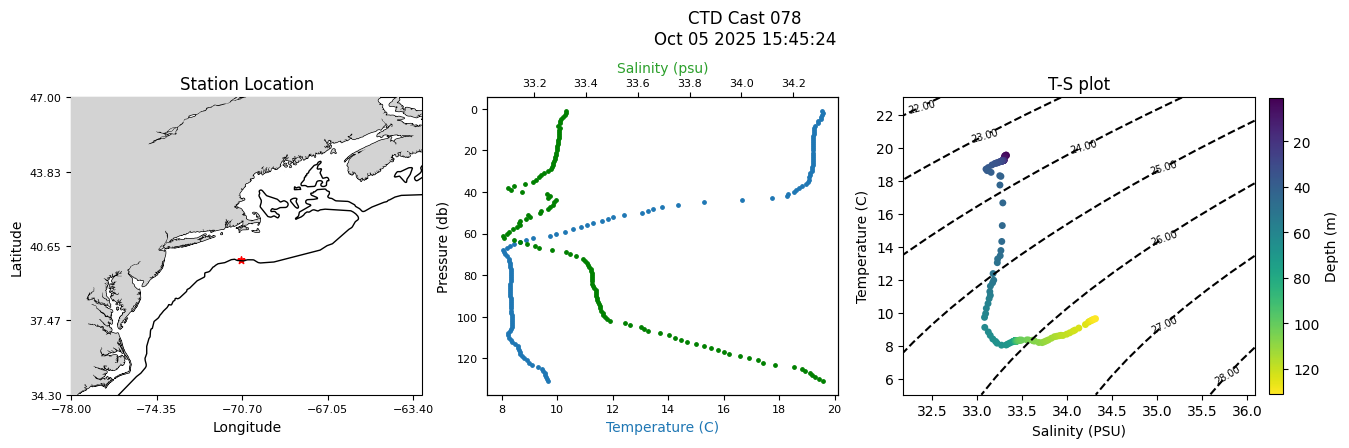

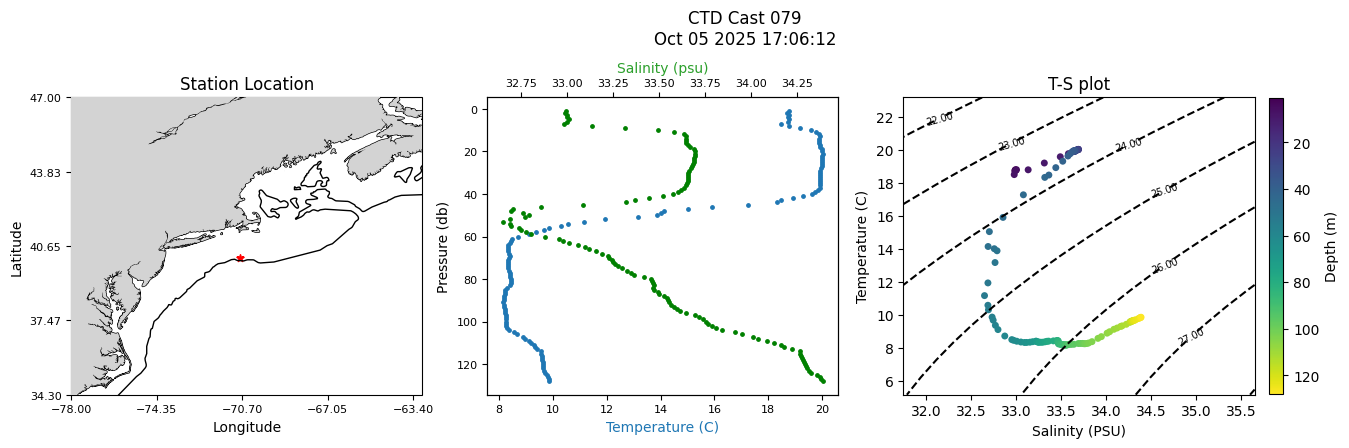

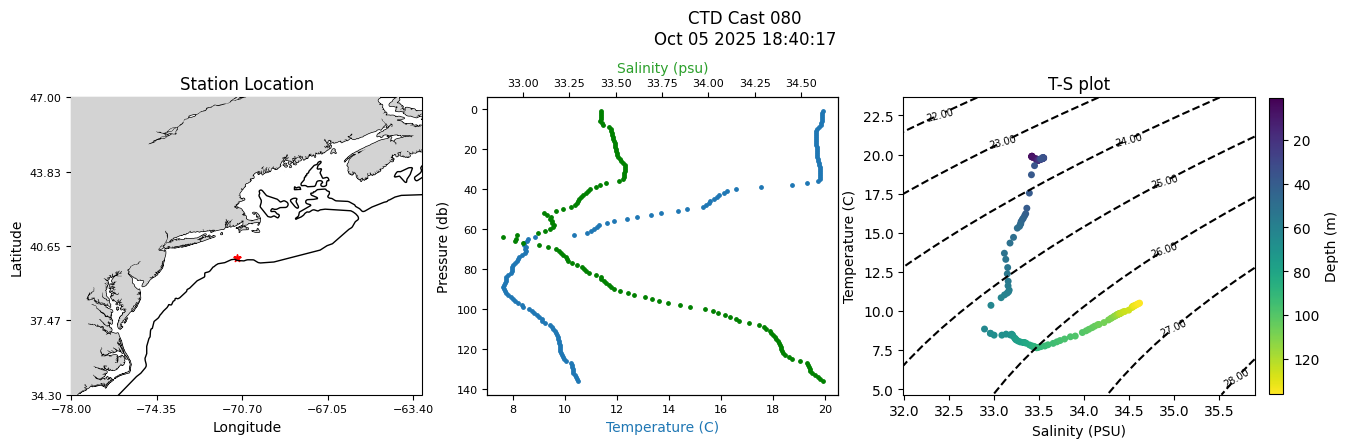

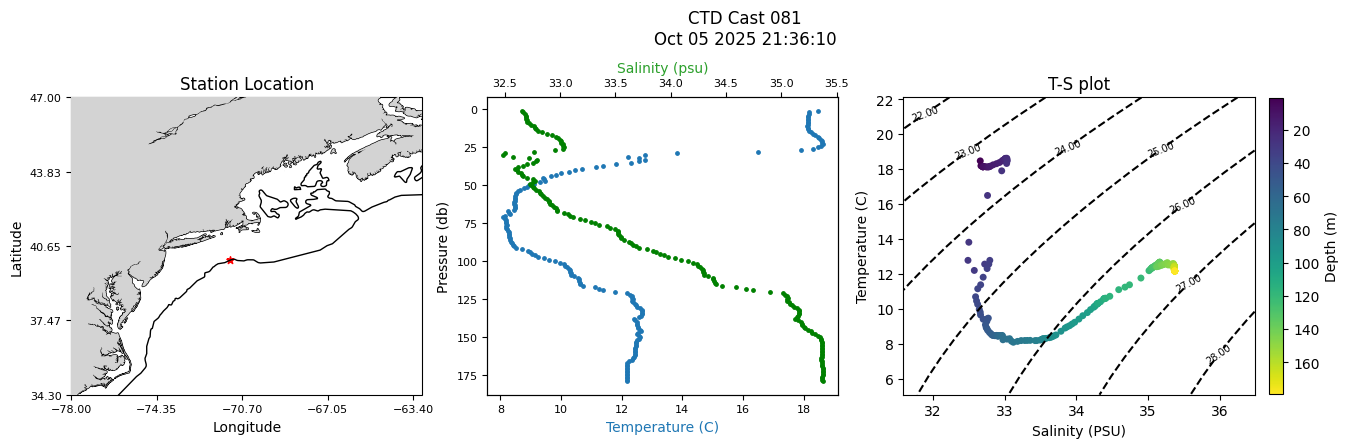

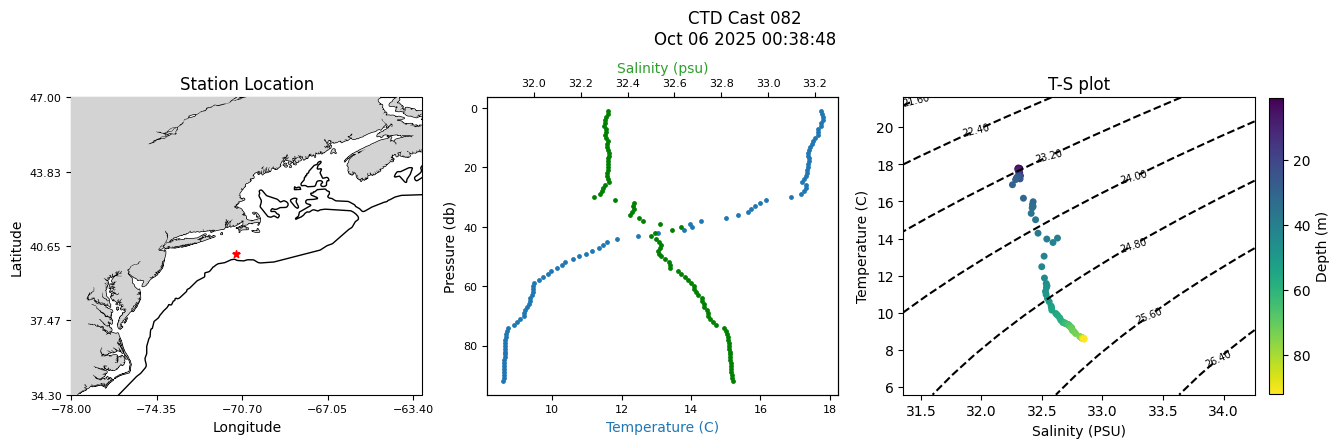

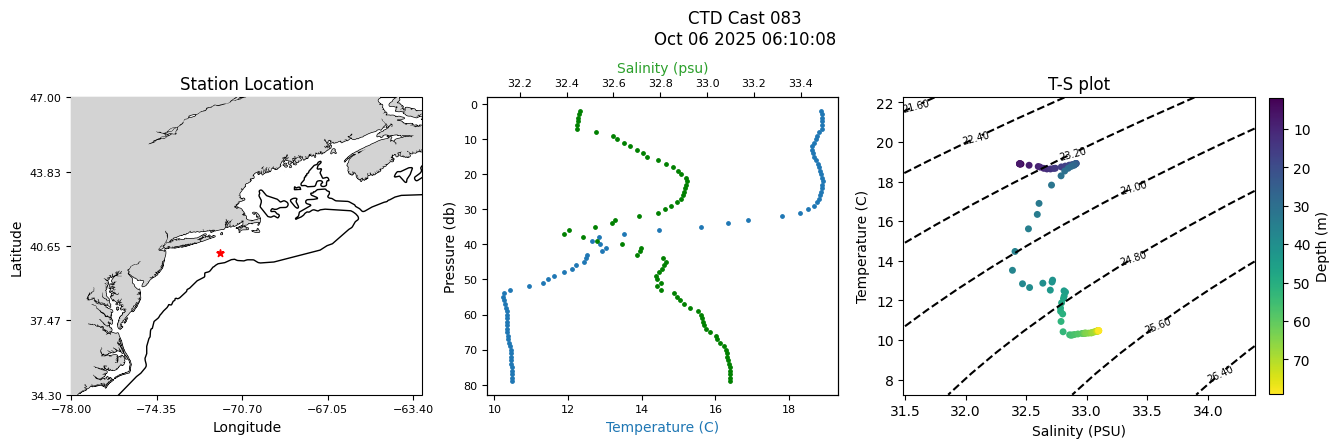

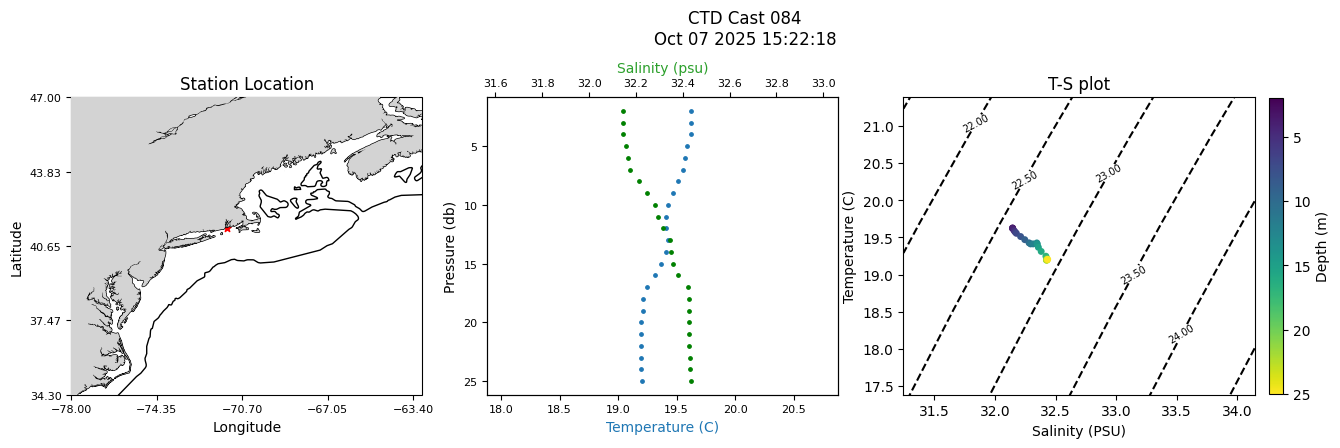

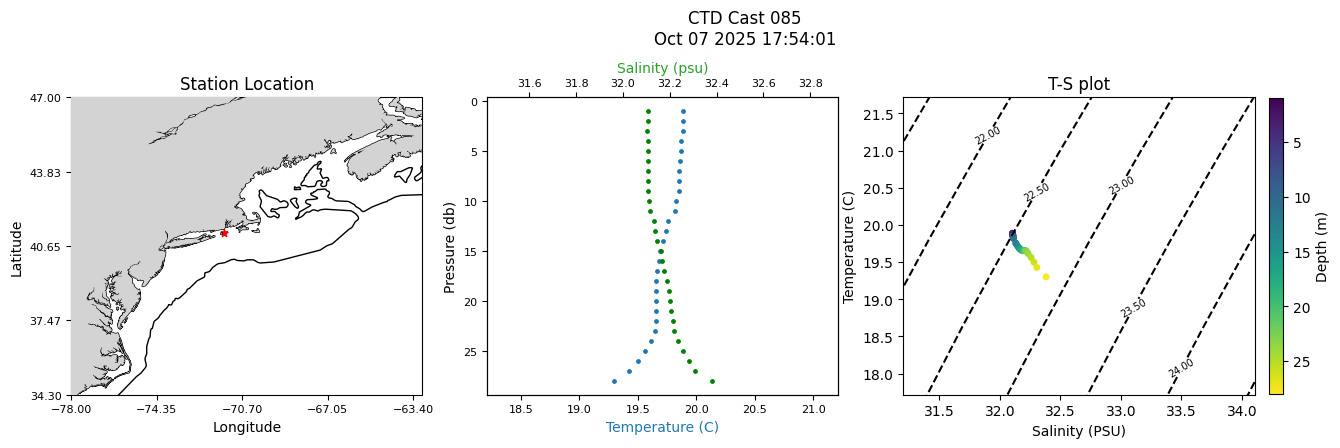

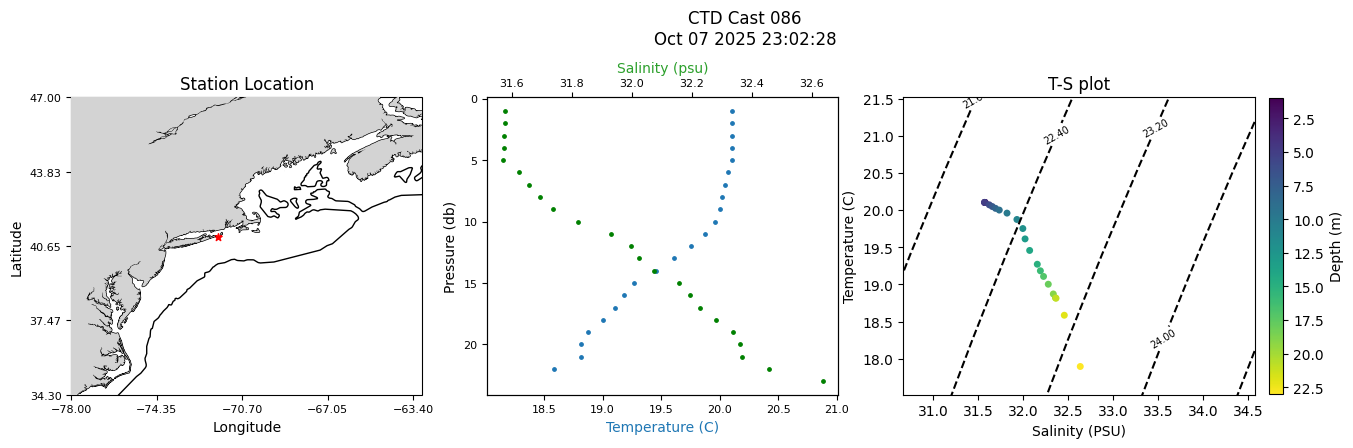

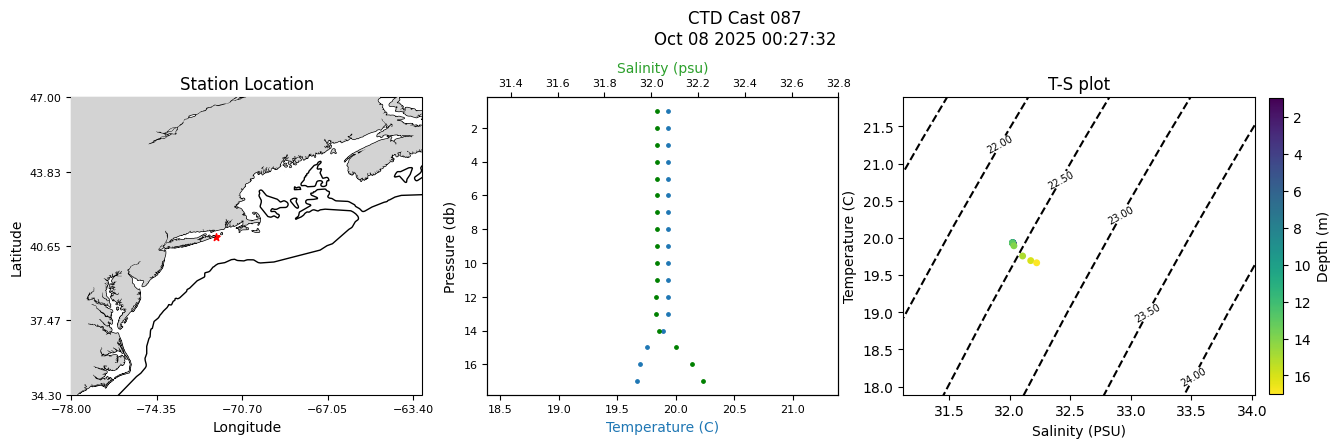

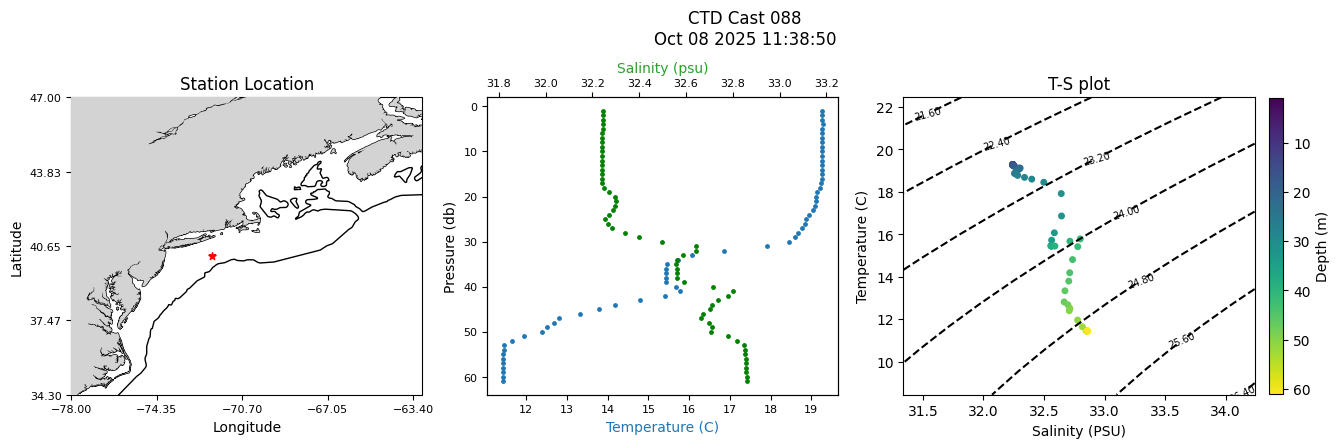

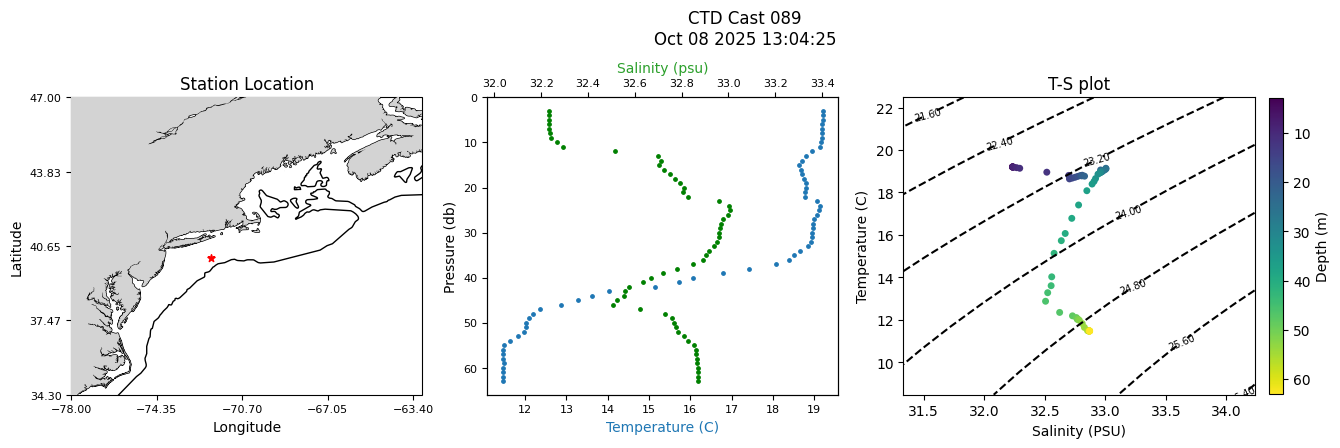

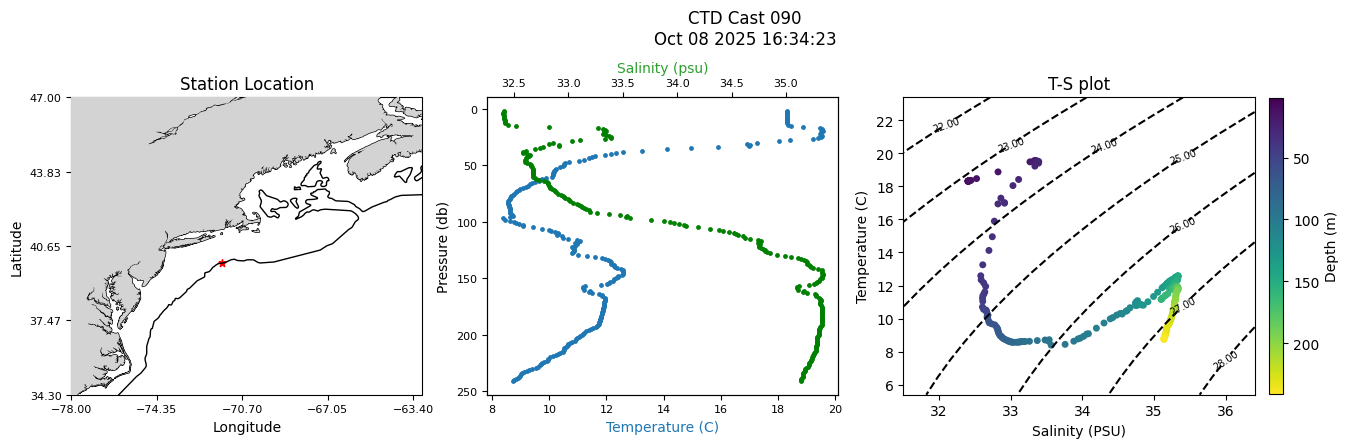

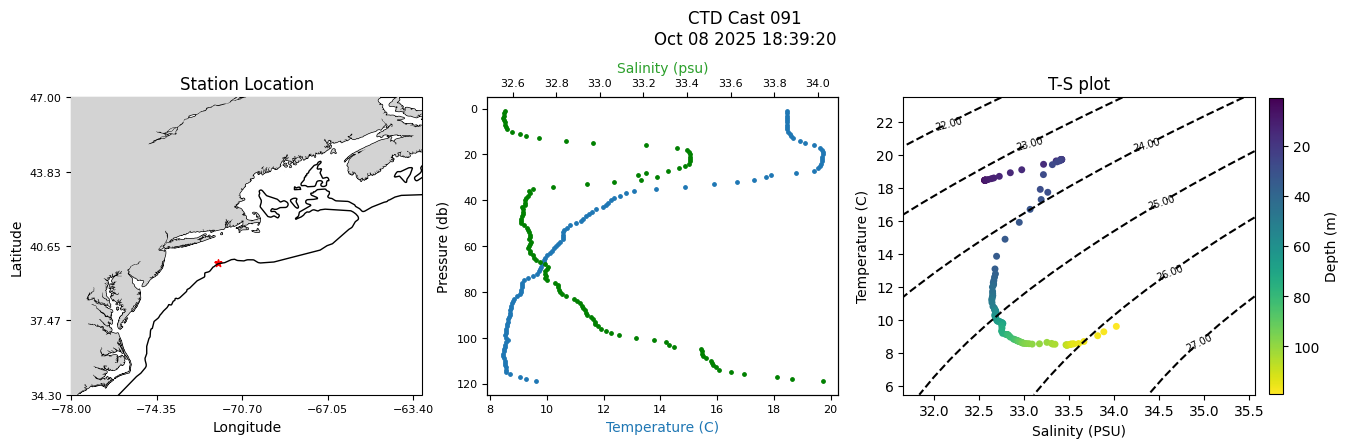

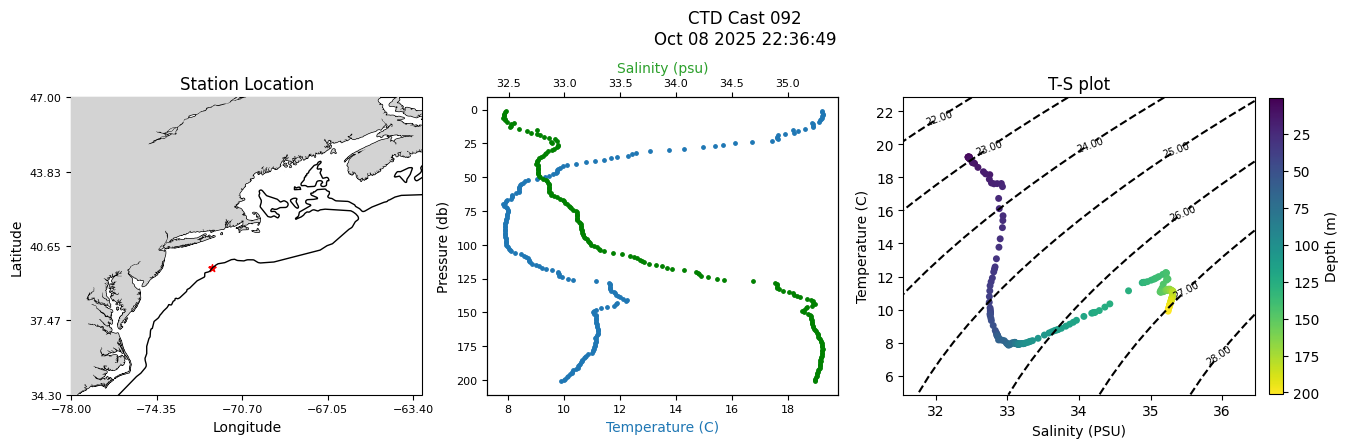

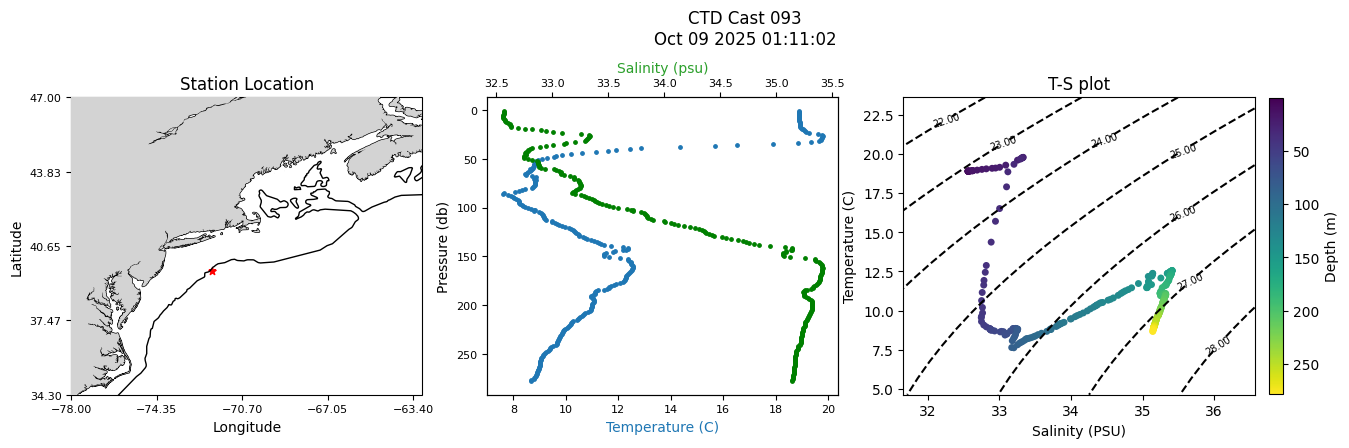

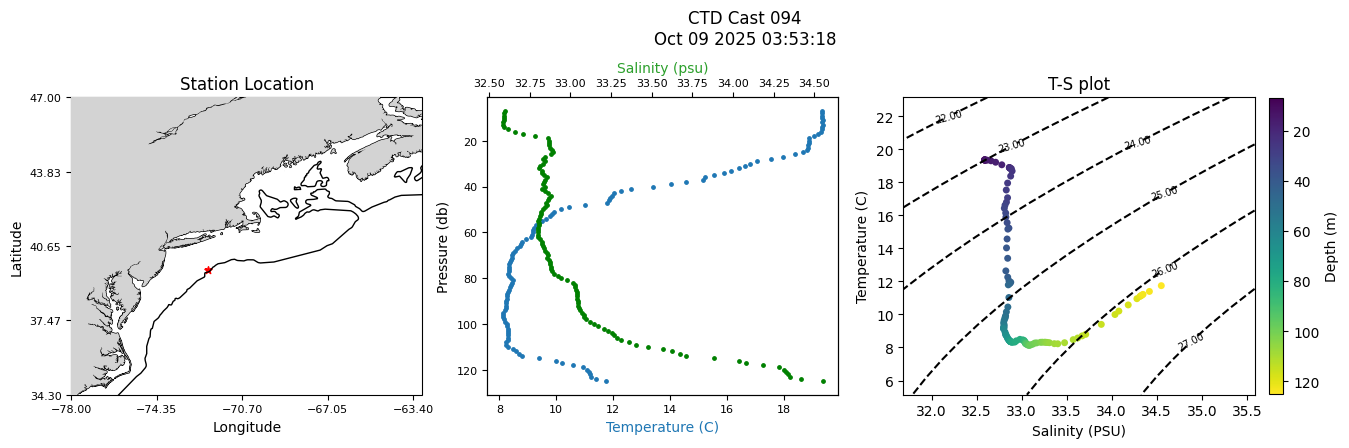

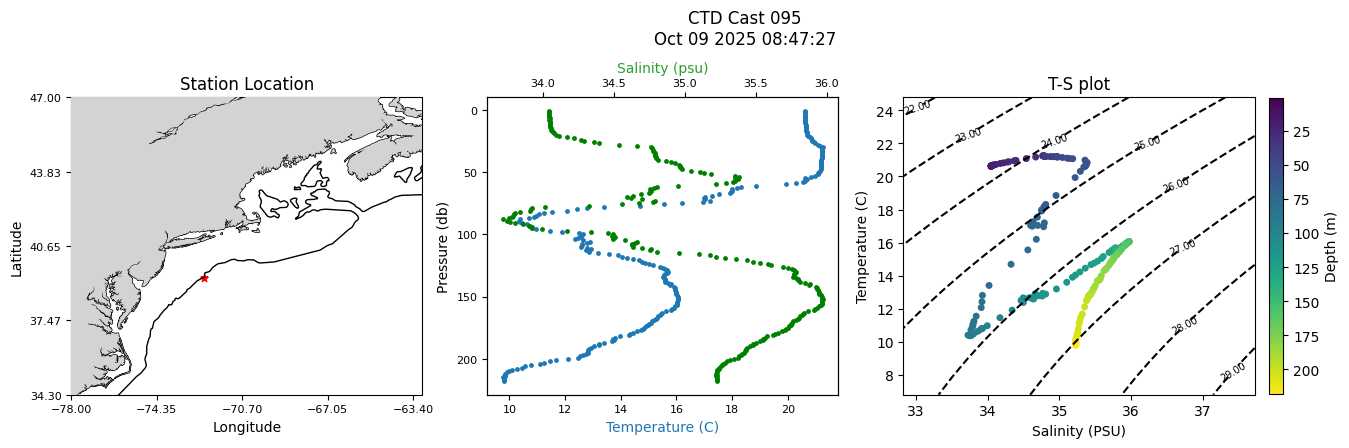

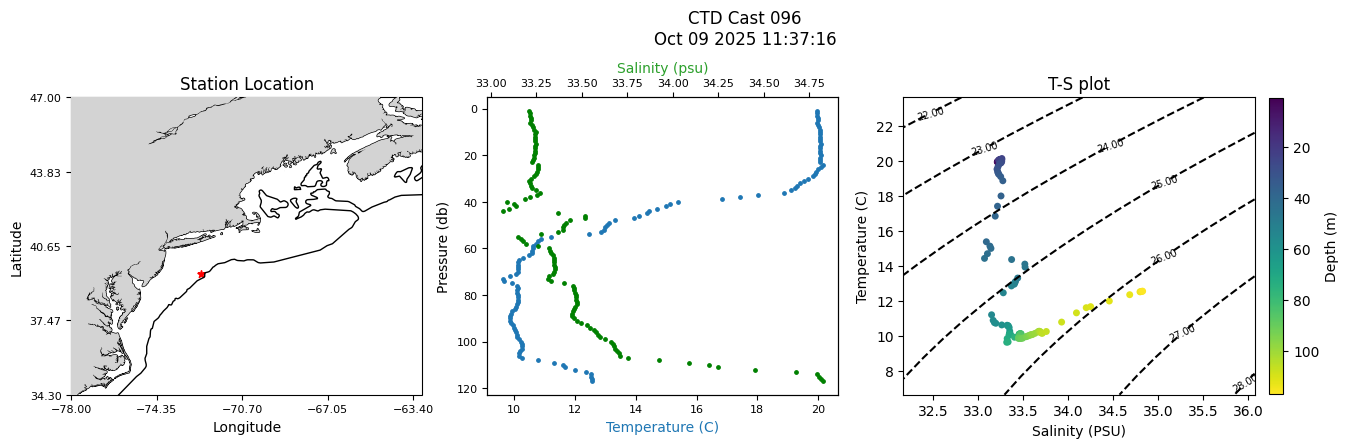

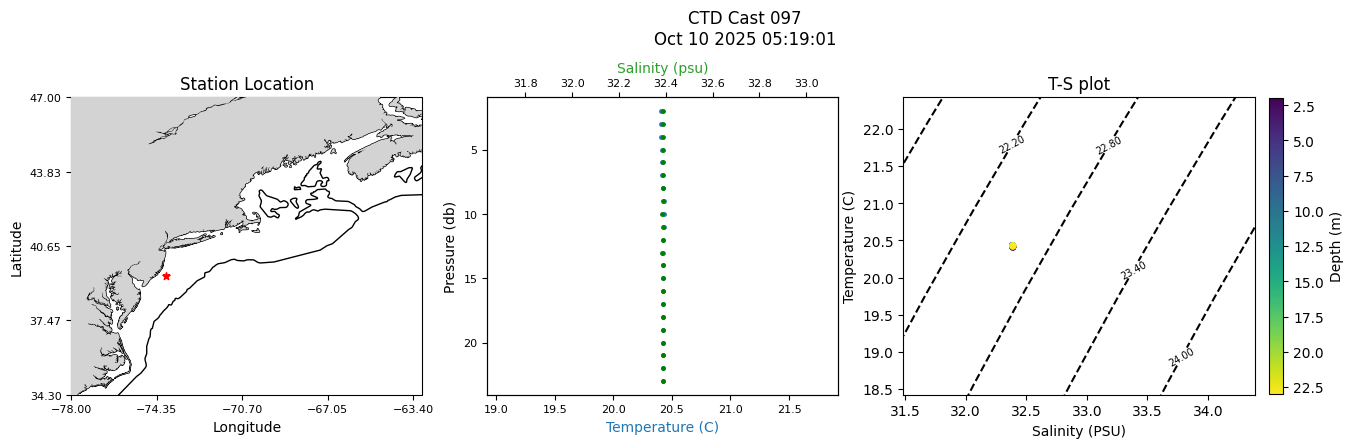

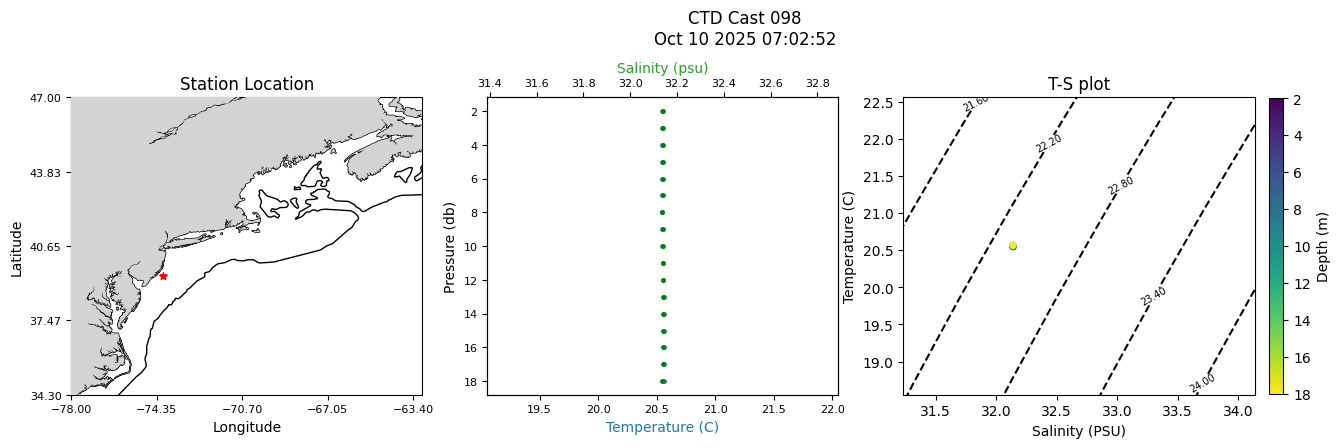

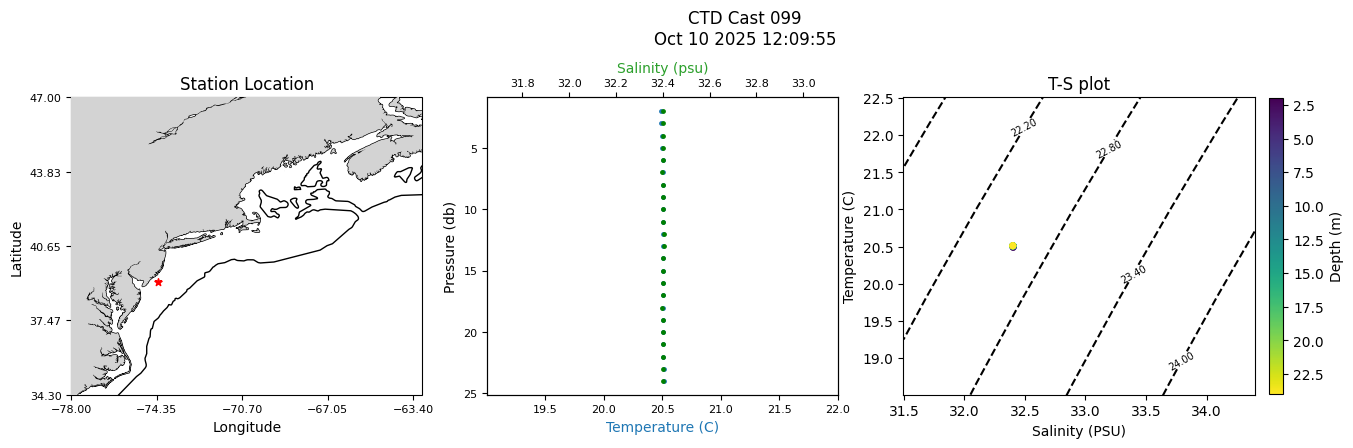

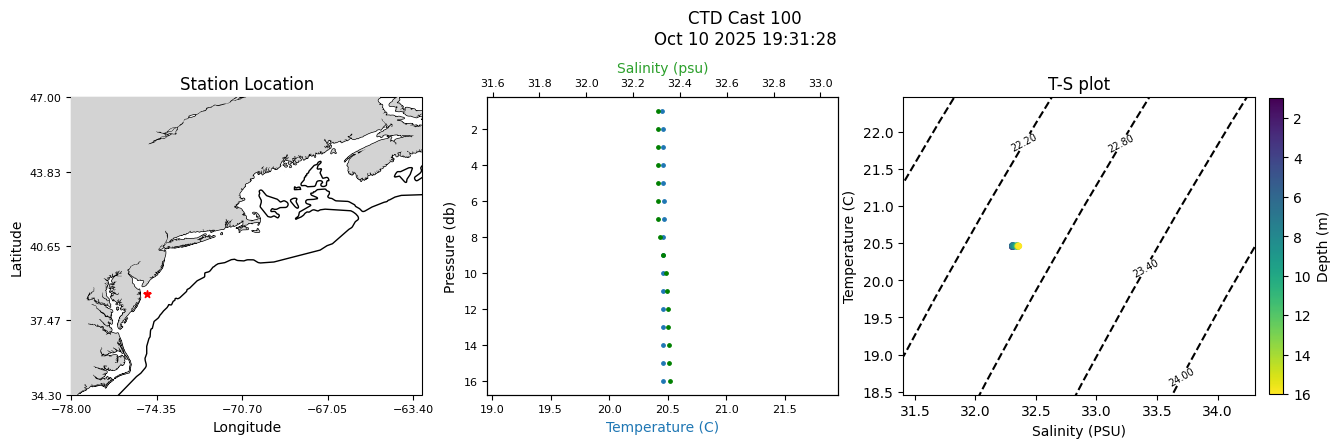

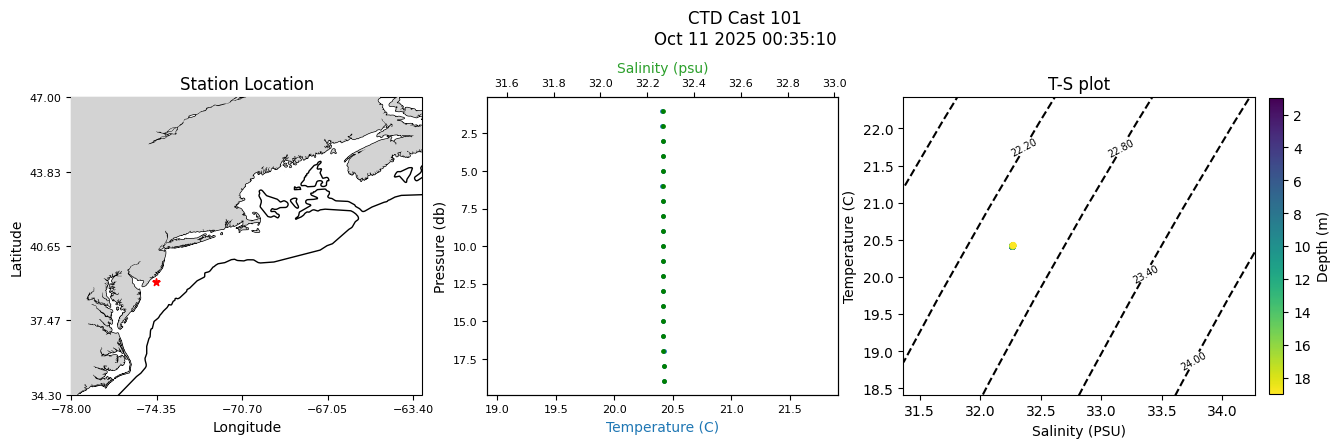

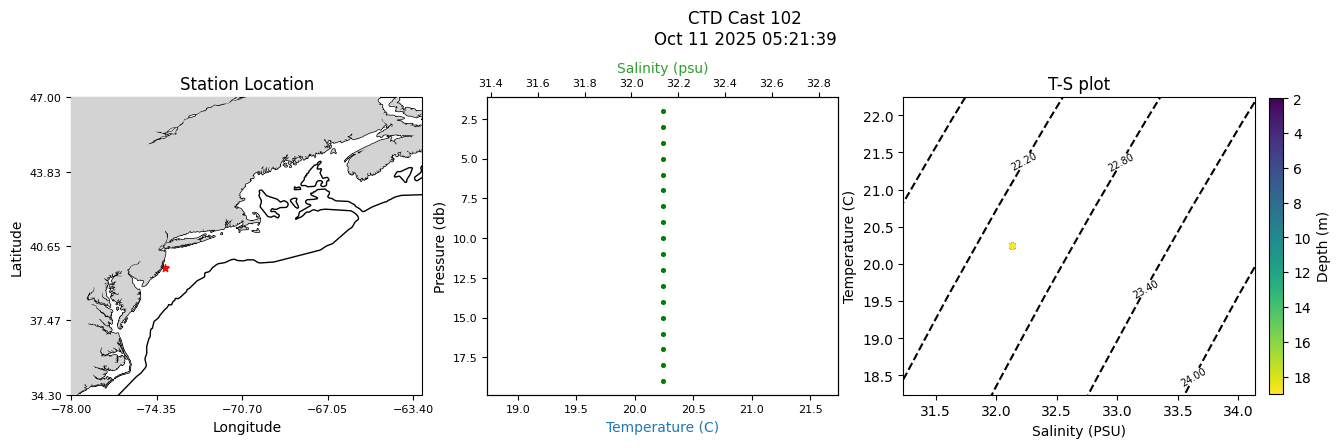

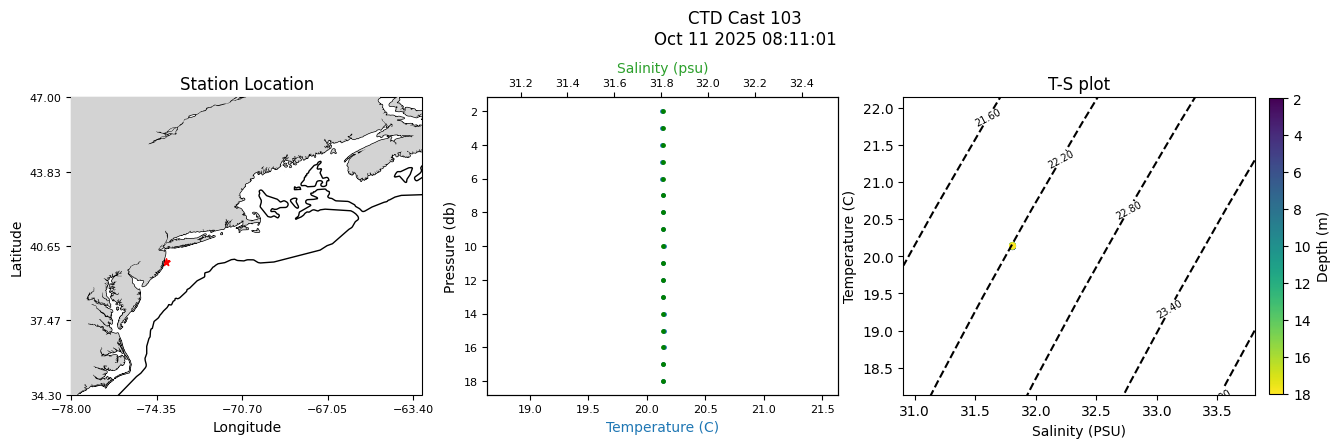

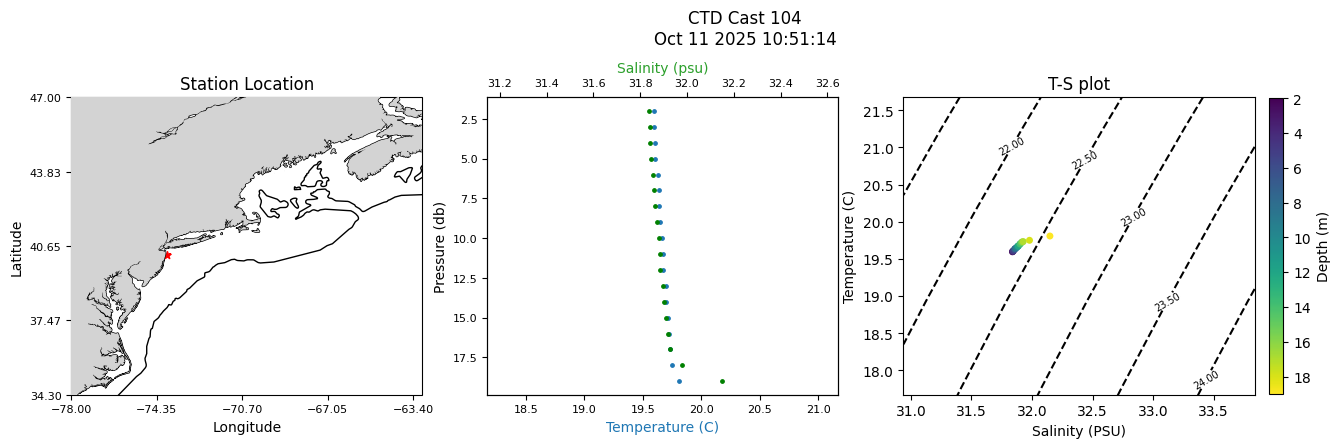

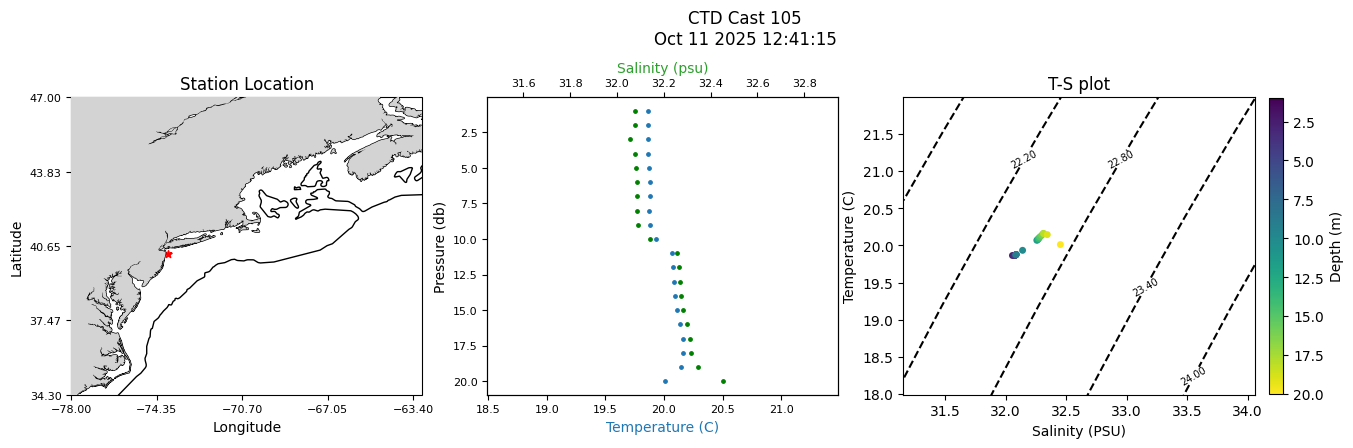

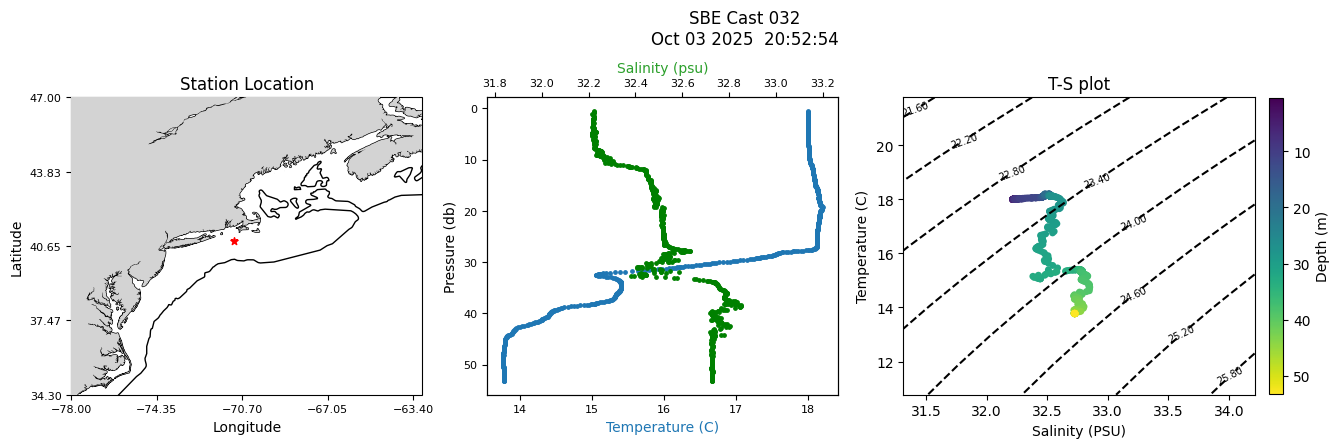

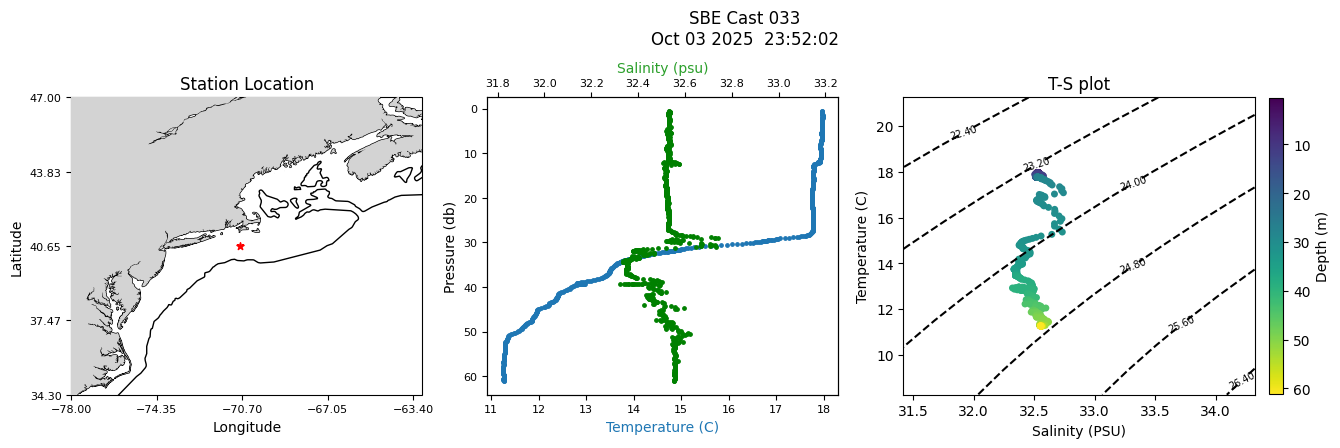

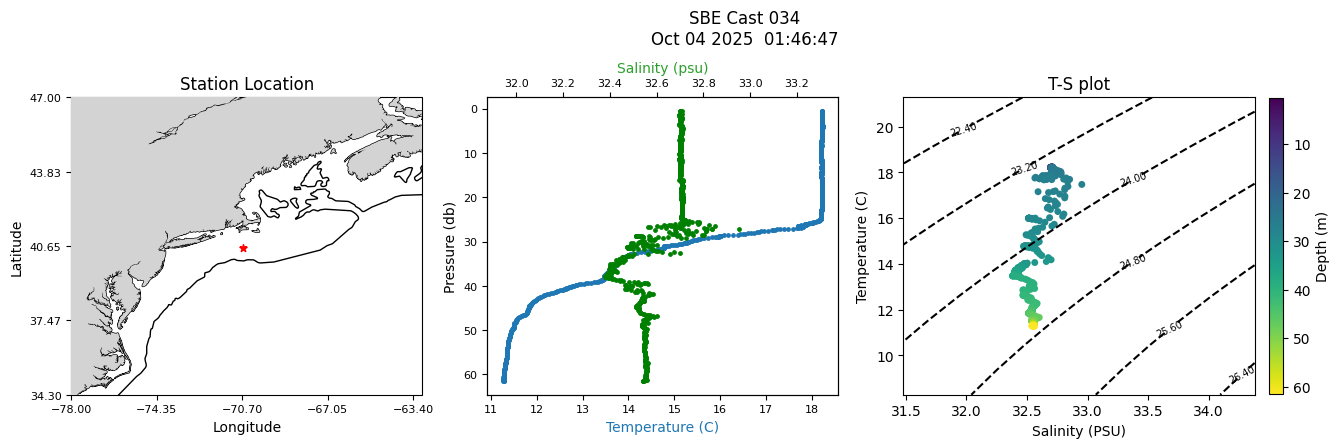

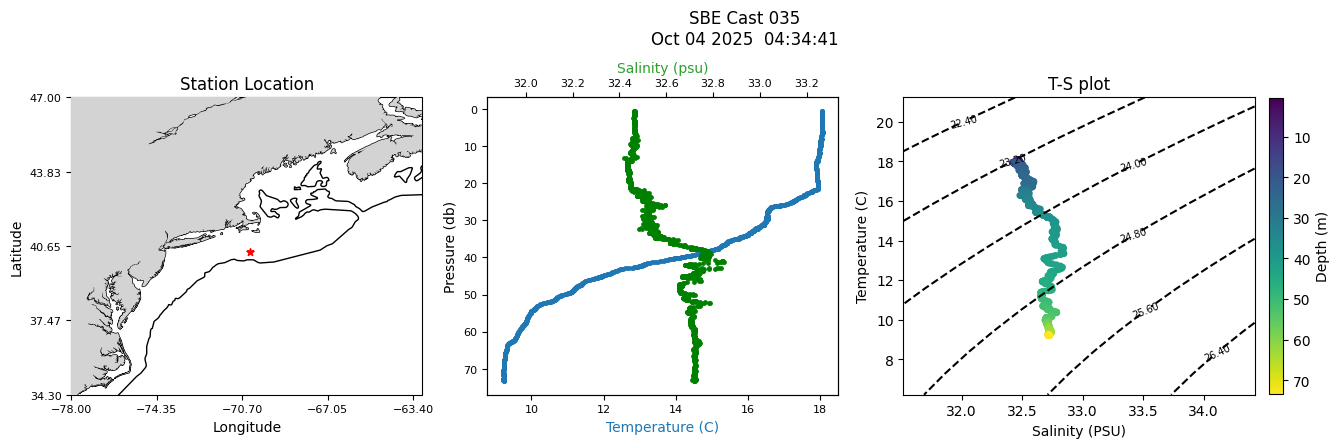

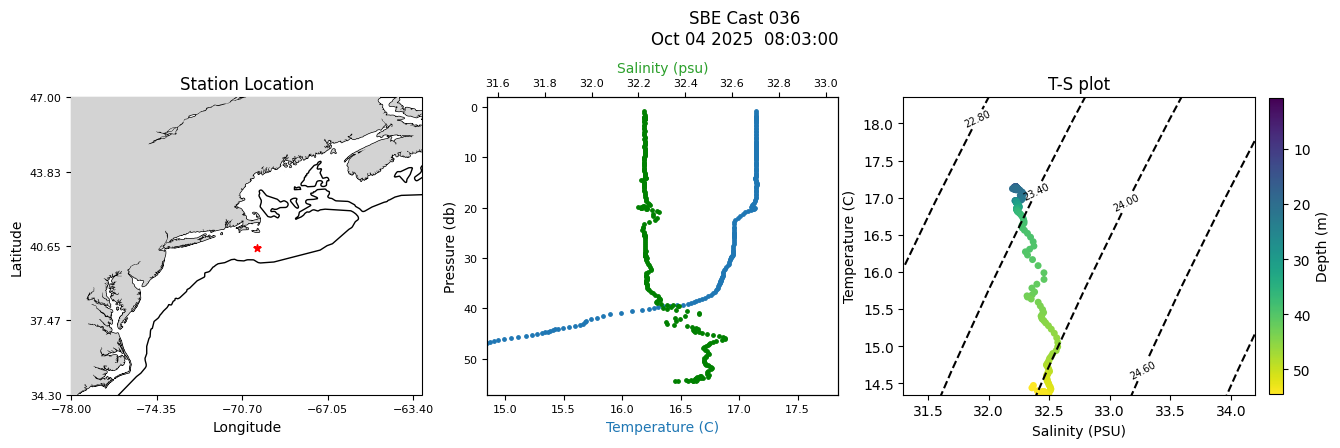

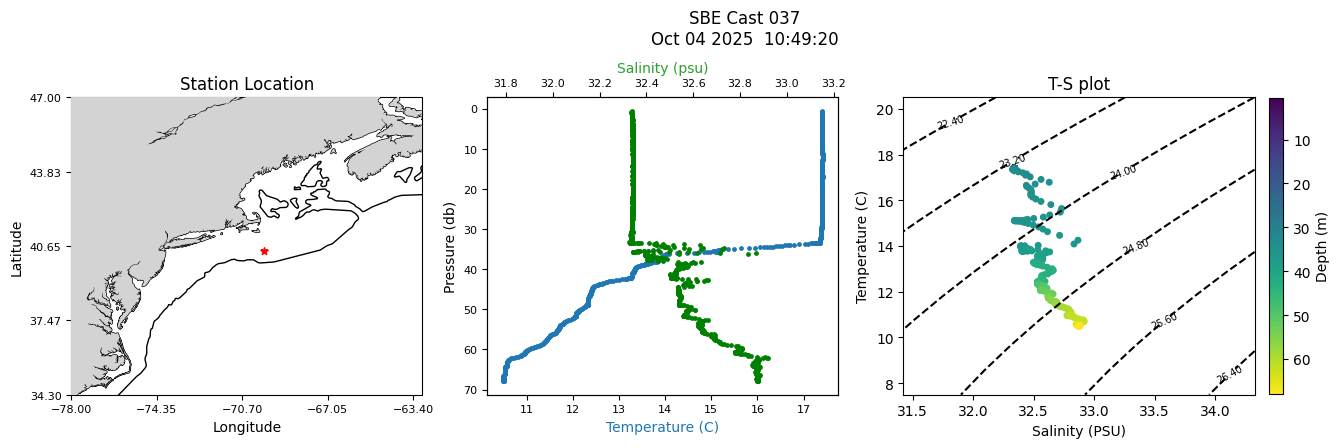

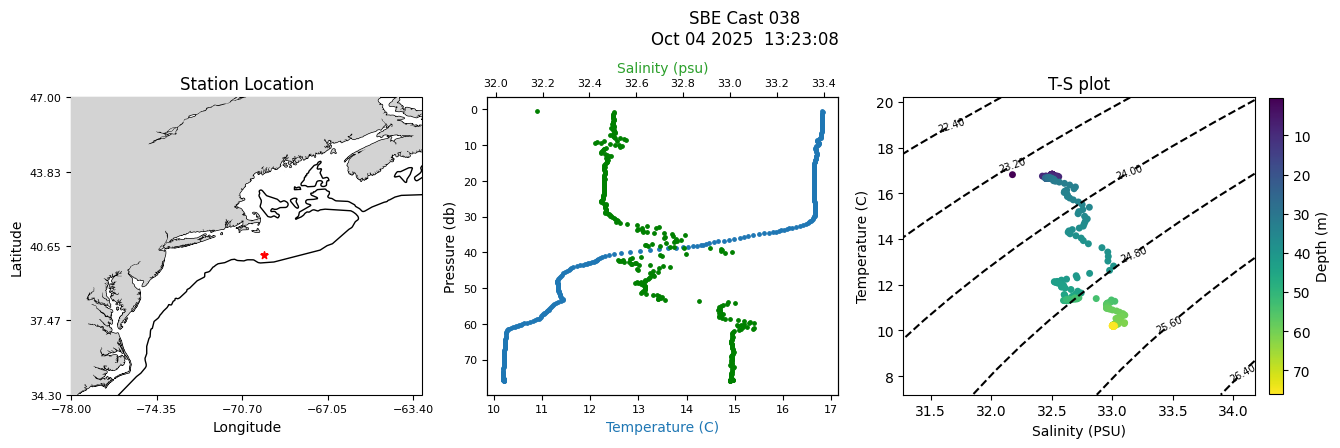

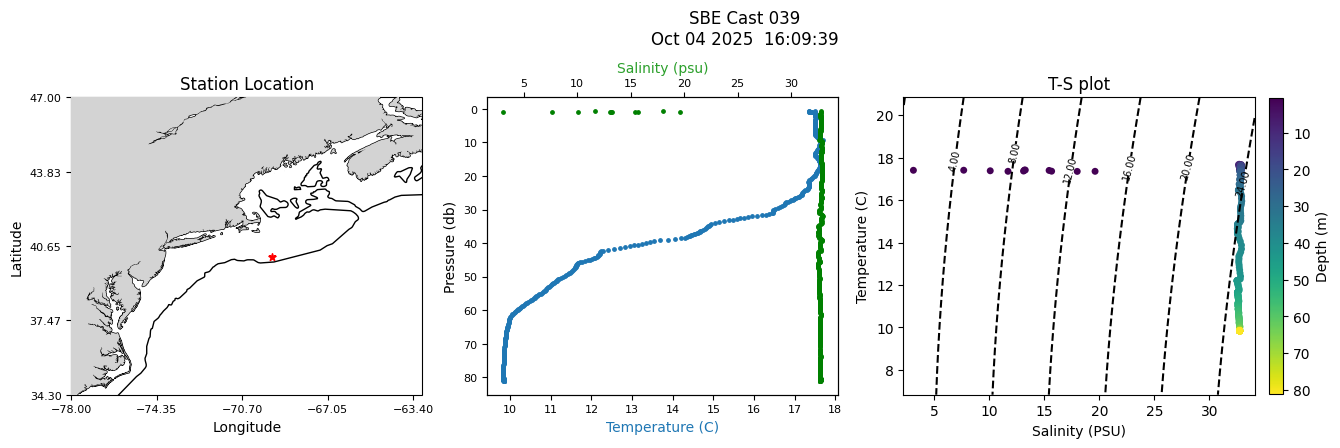

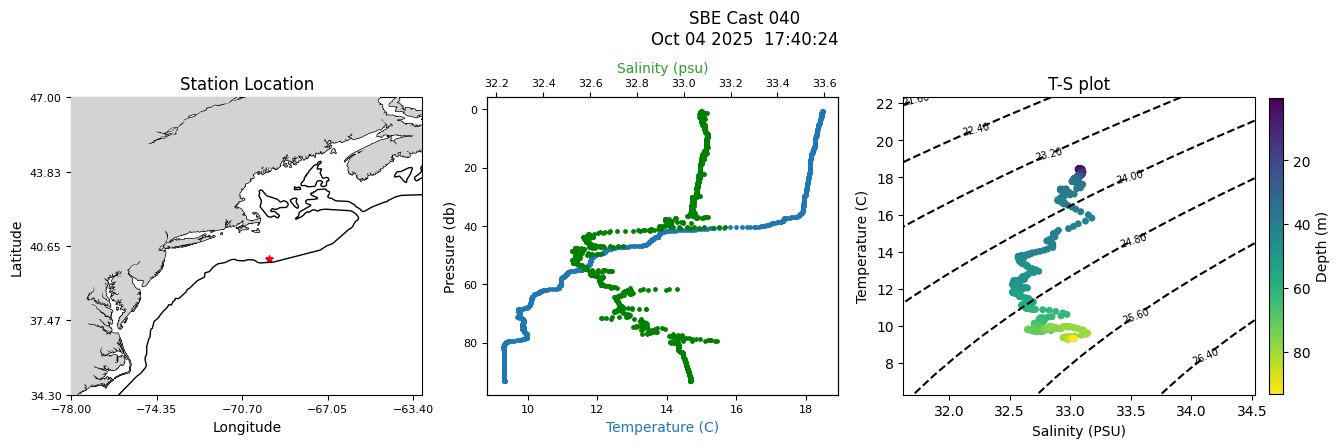

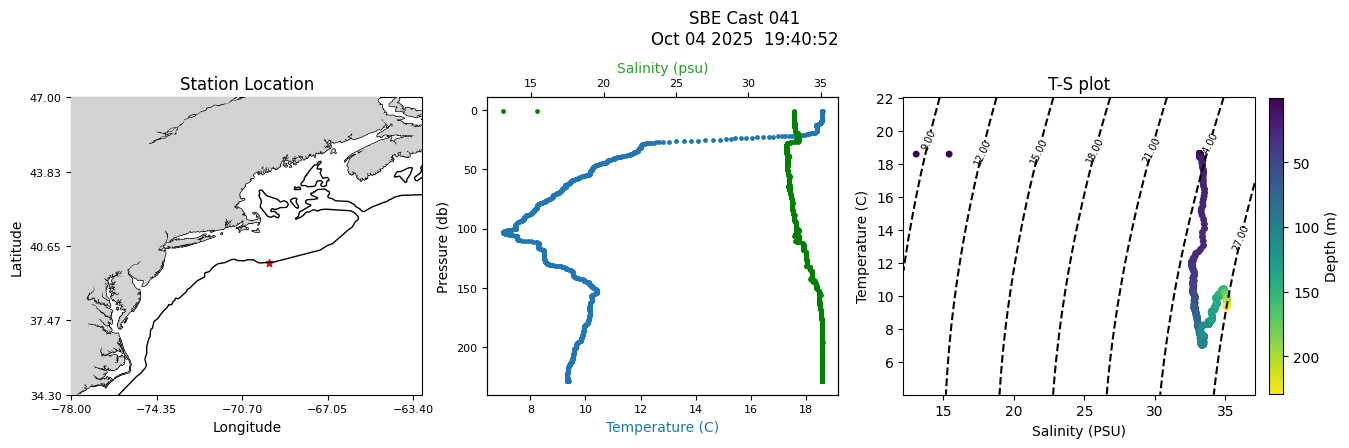

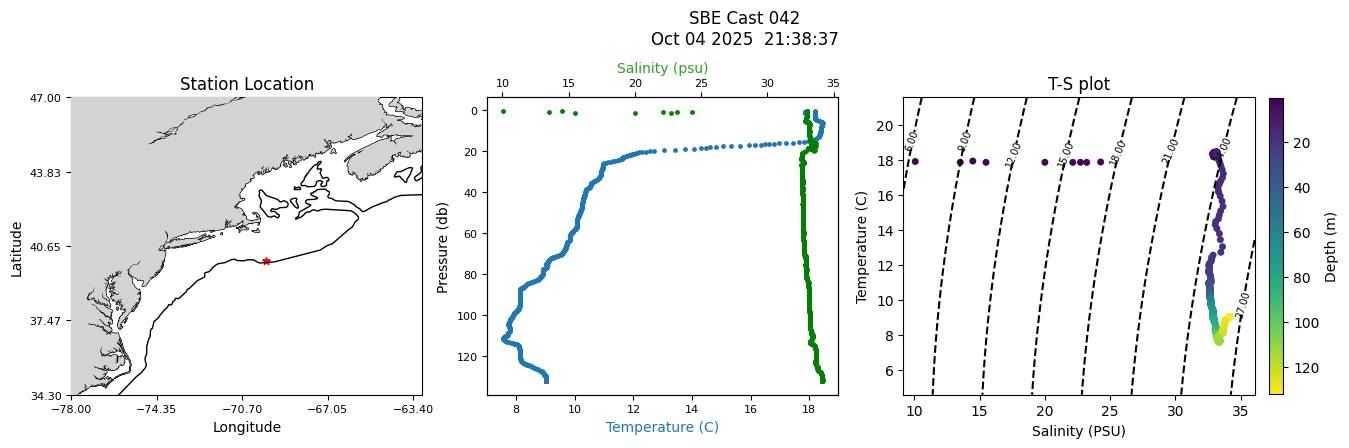

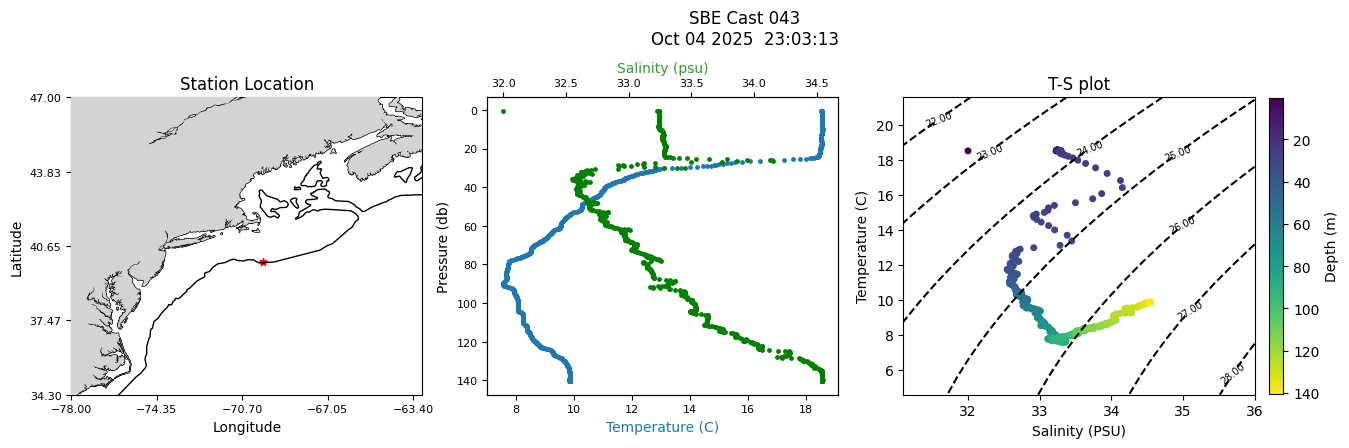

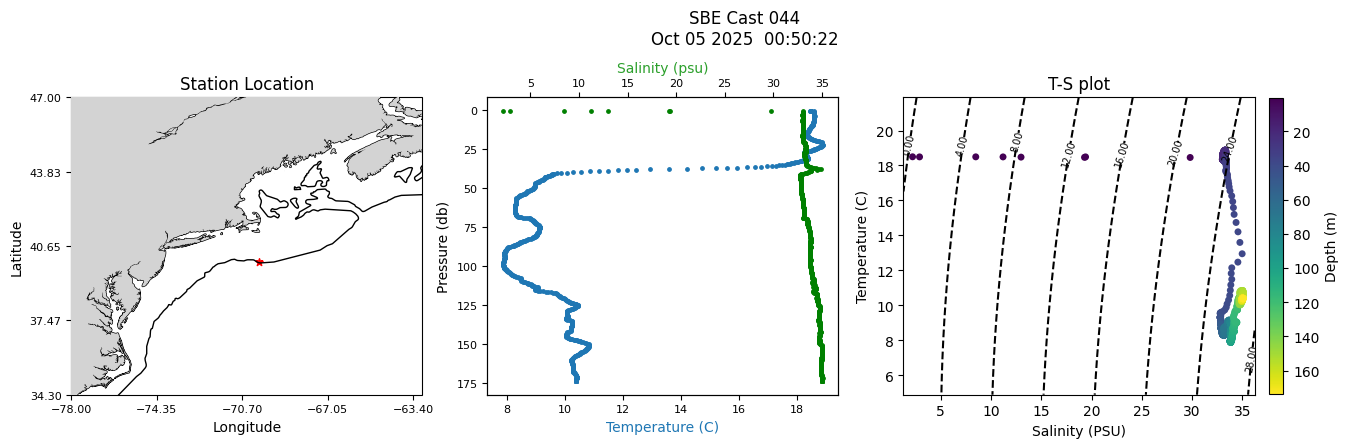

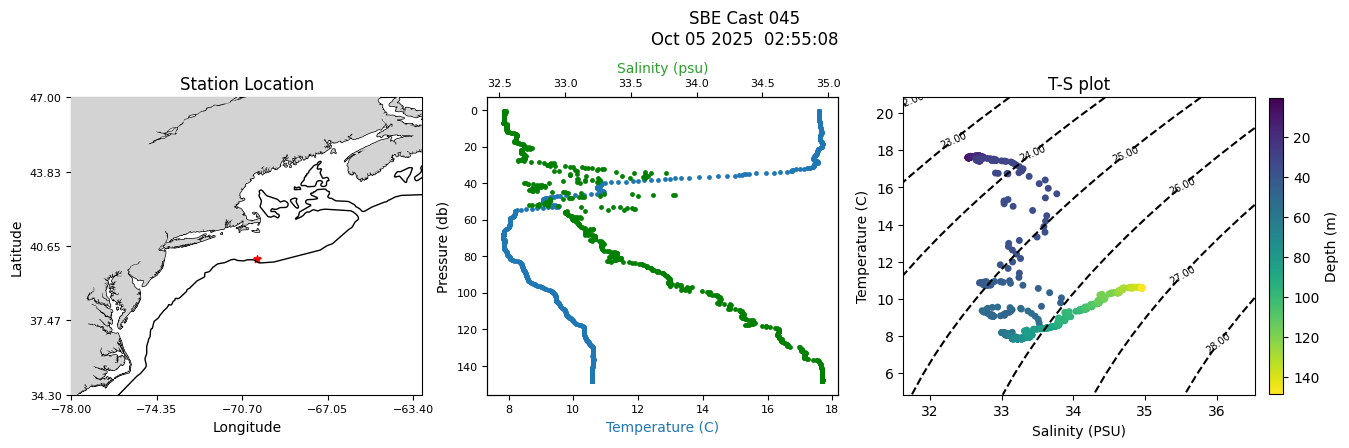

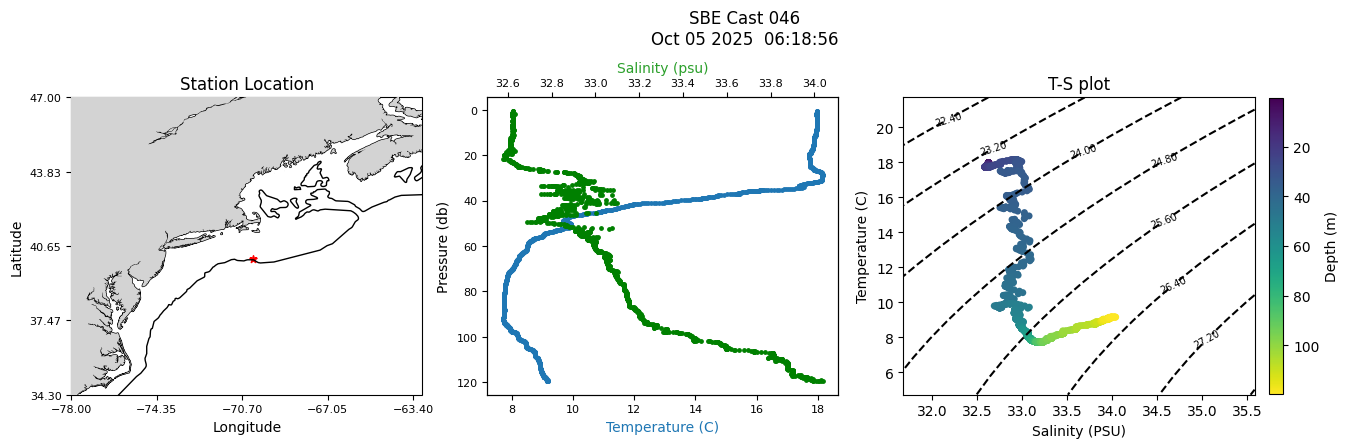

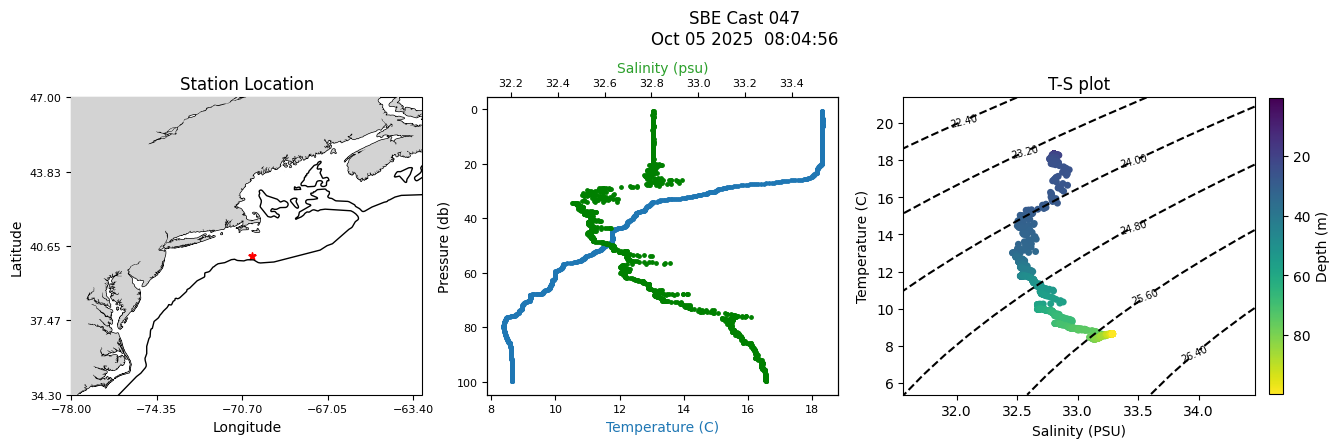

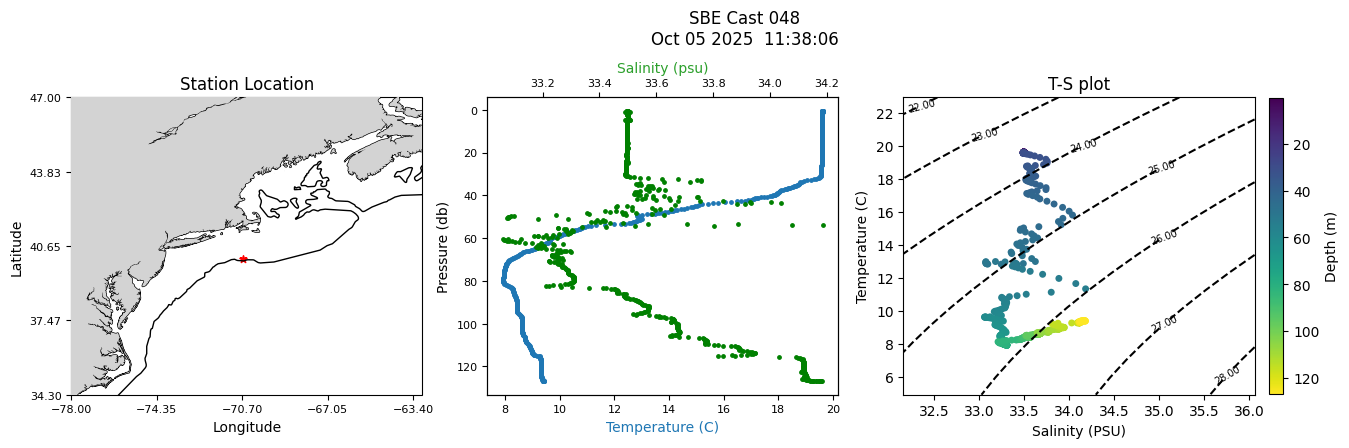

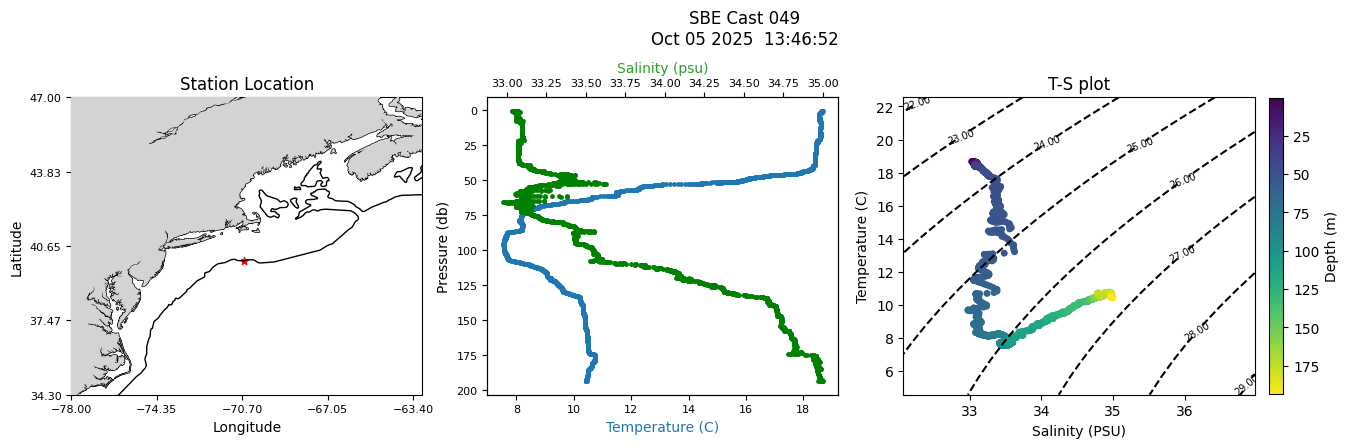

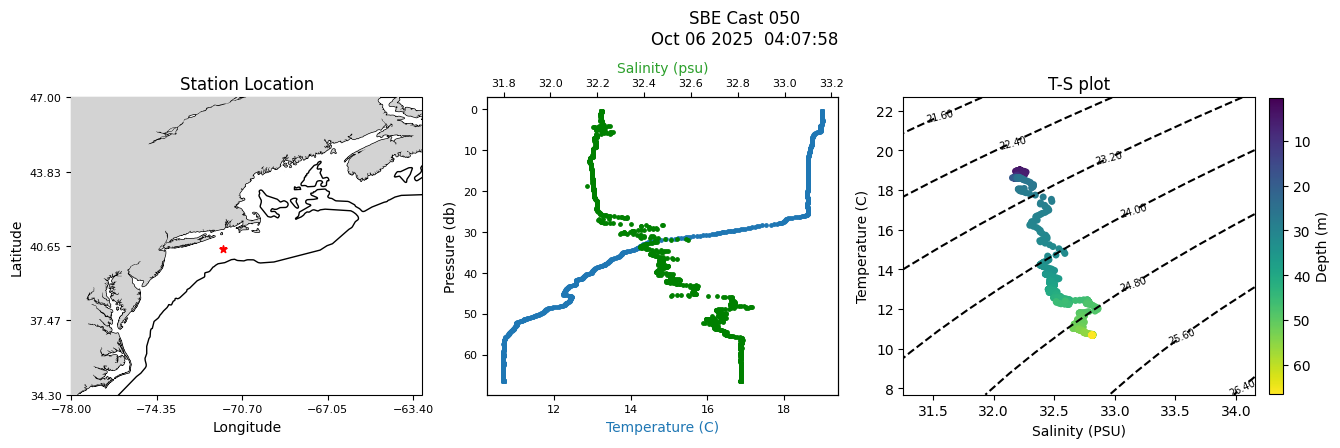

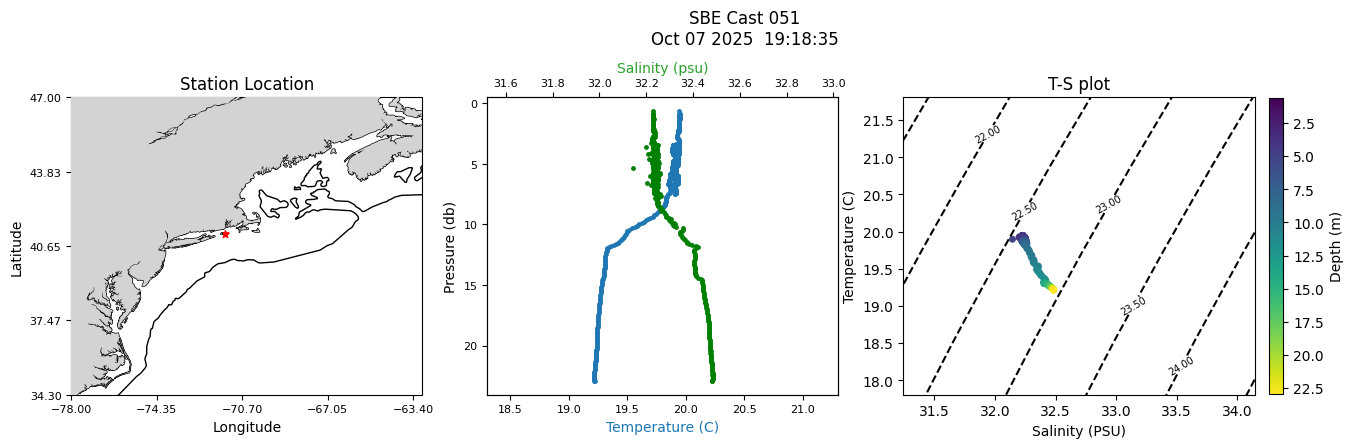

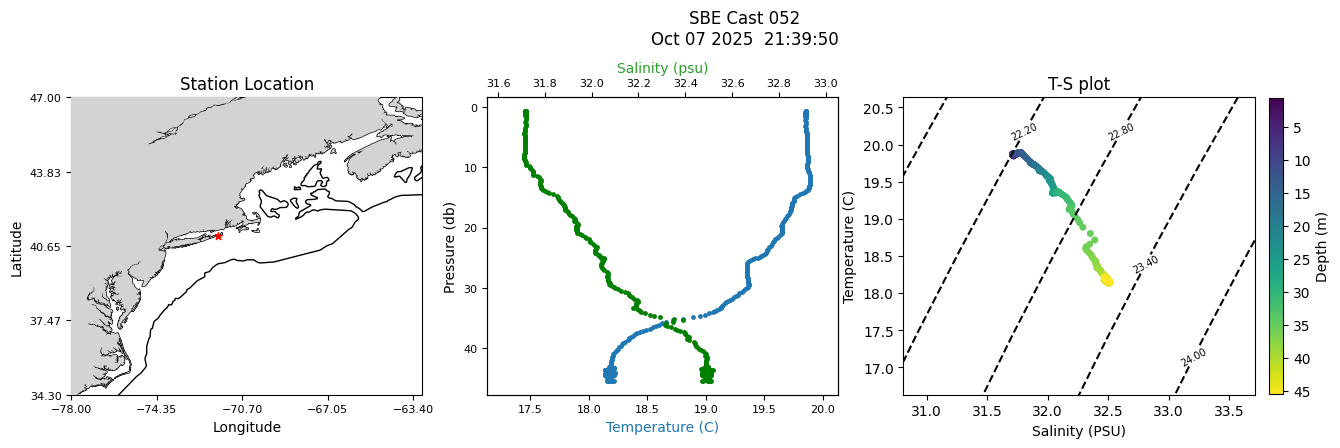

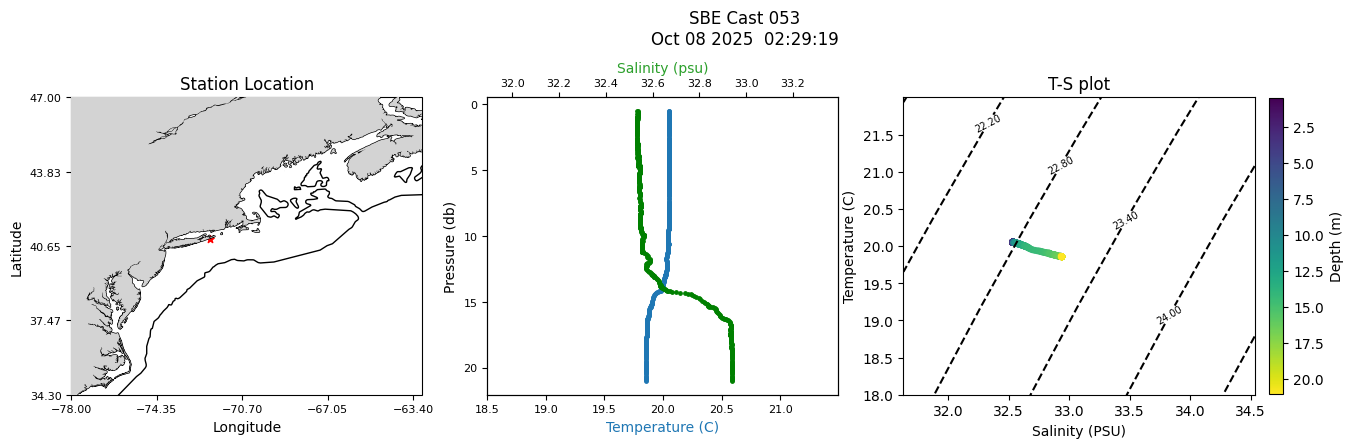

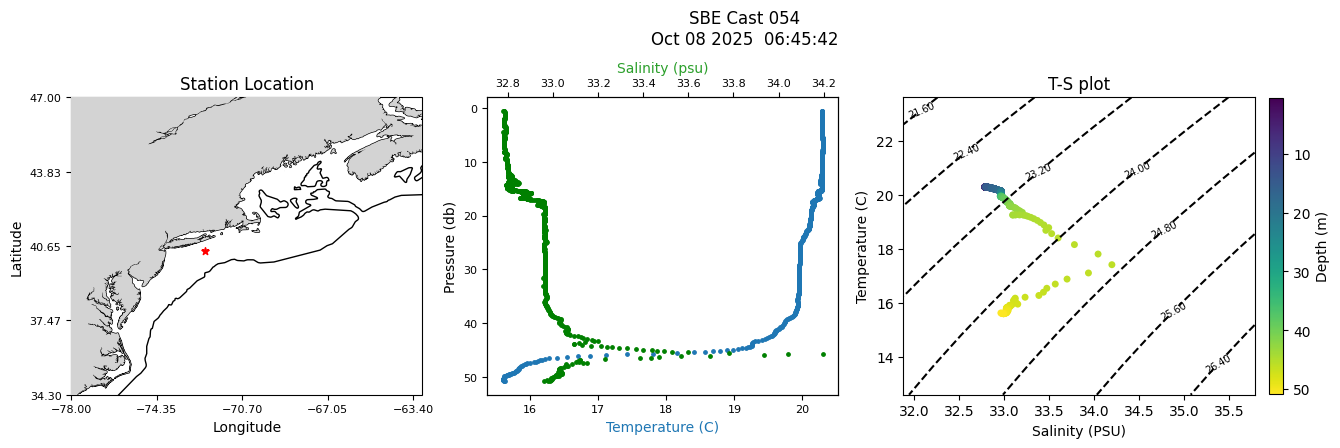

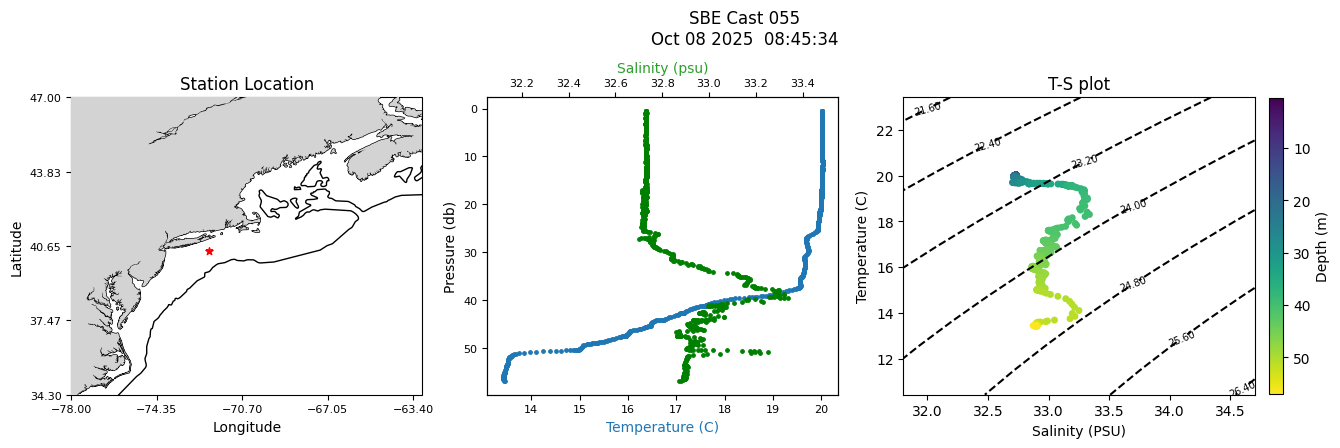

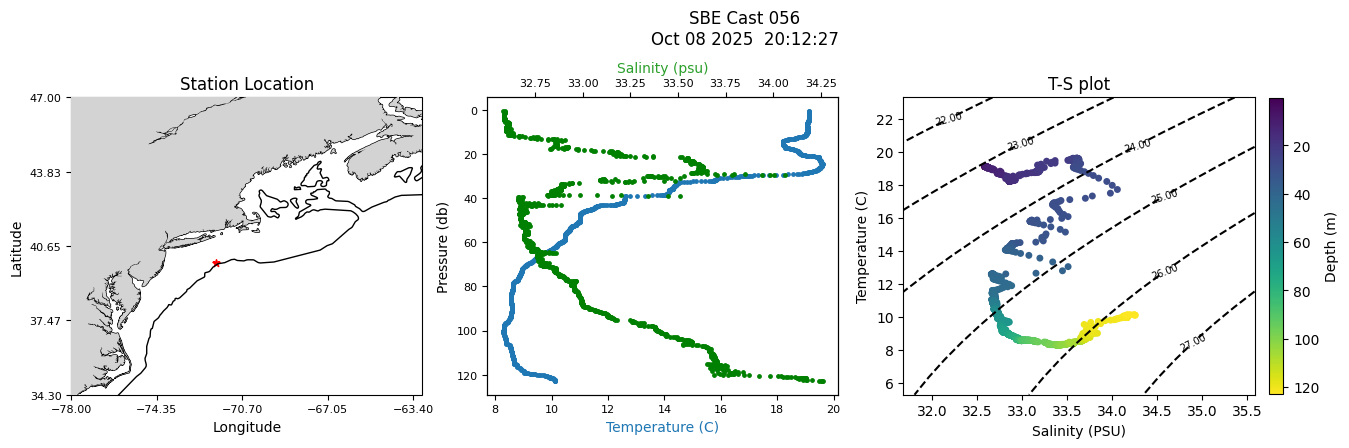

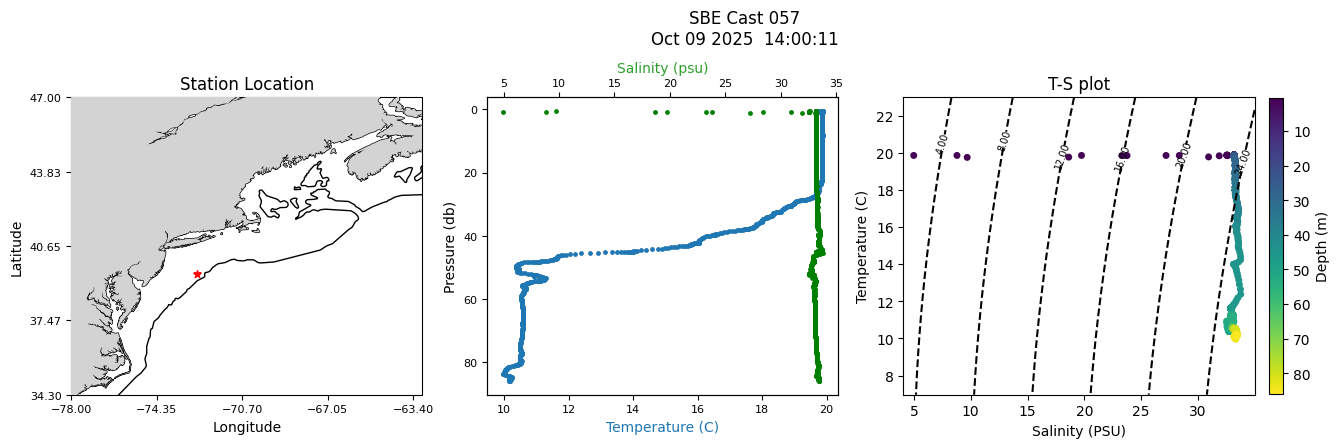

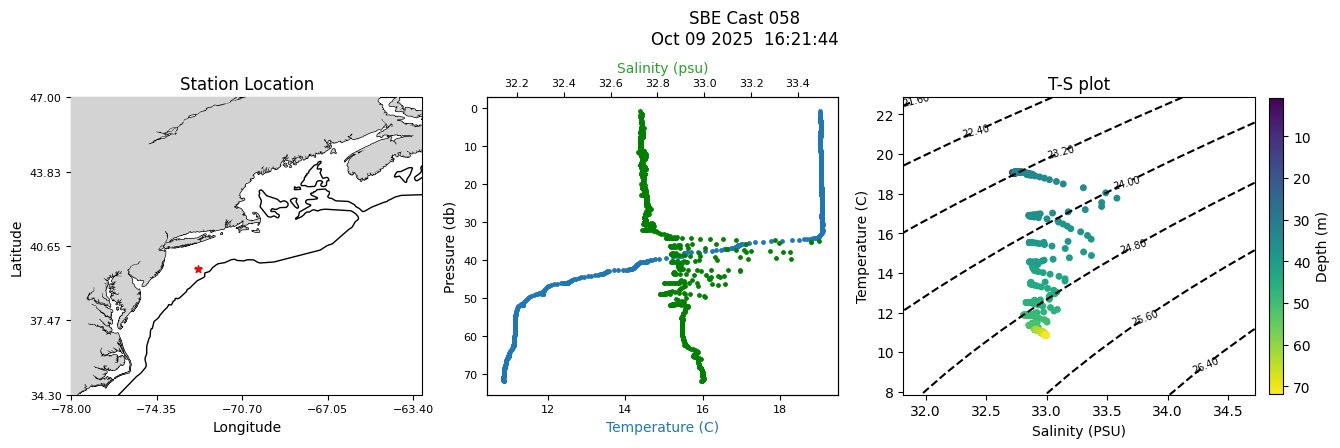

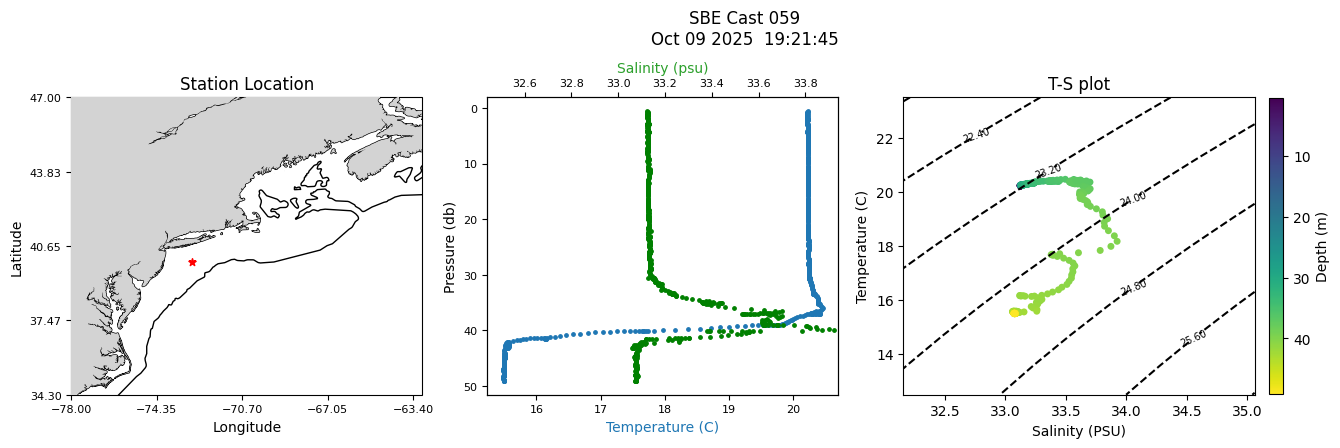

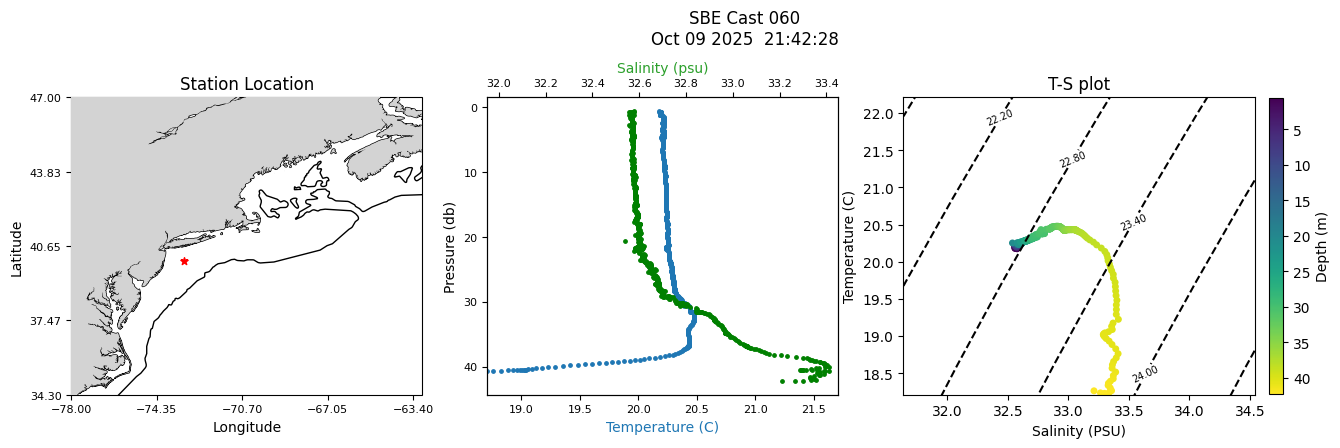

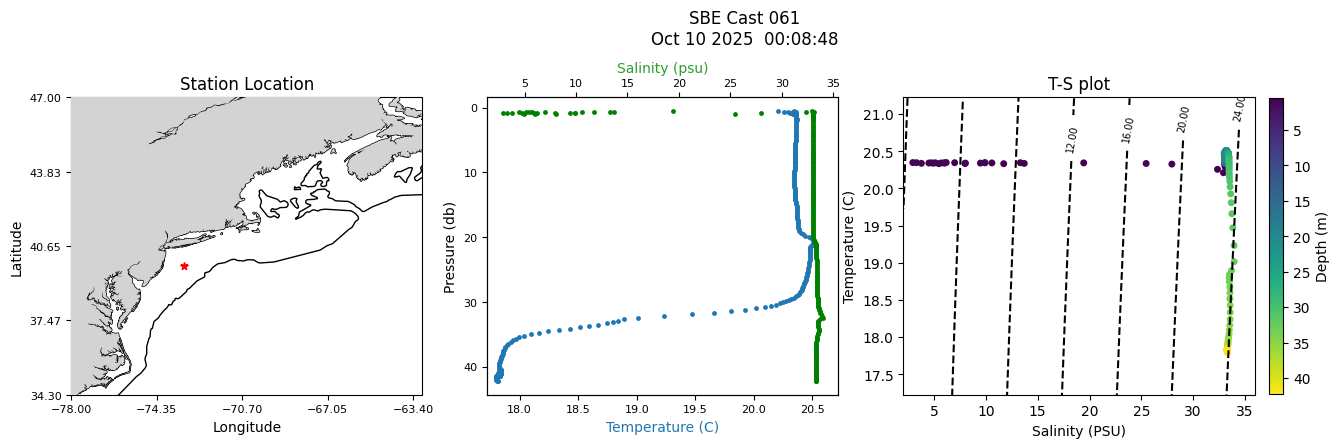

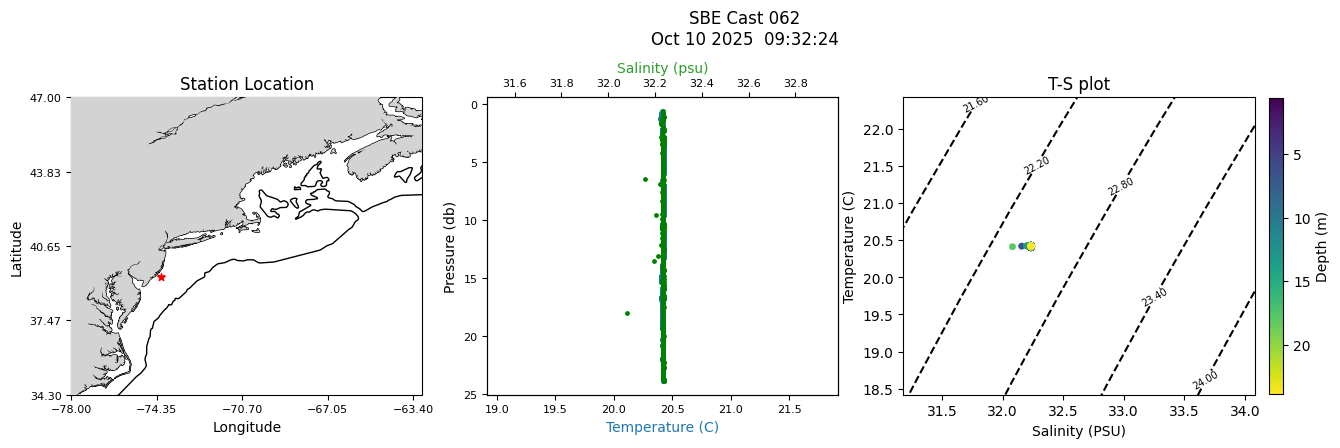

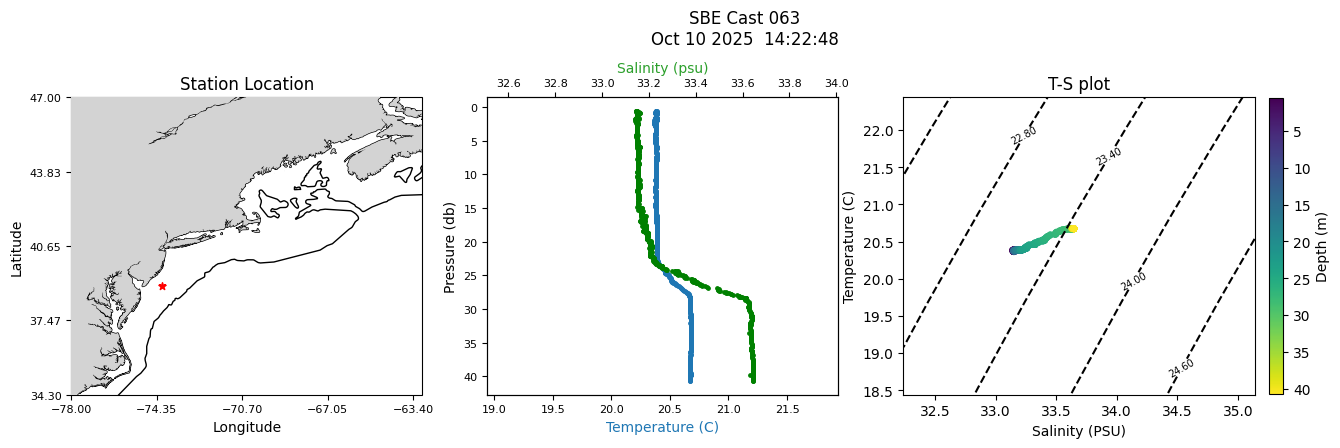

In [14]:
fnames = !gsutil ls gs://nmfs_odp_nefsc/NEFSC_CTD_Program_near_real_time_data/*/*.cnv
fnames=fnames.list

bathym = cfeature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical')
bathym = unary_union(list(bathym.geometries()))

for x in range(len(fnames)): 
    proj_name = fnames[x].split('/')[4]
    data_dir_fold = data_dir+'\\'+proj_name
    plotdir=data_dir+'\\'+proj_name+'\PLOTS'
    cast=[]
    if fnames[x].split('/')[5] == 'ctd999.cnv':
        pass
    else: 
        file = data_dir_fold+'\\'+fnames[x].split('/')[5]
        if os.path.isfile(file):
            continue
        else: 
            try: 
                down, up = ctd.from_cnv(file).split()
                cast = up.reset_index().rename(columns={"Pressure [dbar]": "pres"})
                cast= cast[cast.pres>0.5] #remove negative pressures
            except:
                urllib.request.urlretrieve('https://storage.googleapis.com/'+fnames[x].split('//')[1],file)
                down, up = ctd.from_cnv(file).split()
                cast = up.reset_index().rename(columns={"Pressure [dbar]": "pres"})
                cast= cast[cast.pres>0.5] #remove negative pressures
            try:
                file = fCNV(file)
                lat = file.attributes['LATITUDE']
                lon = file.attributes['LONGITUDE']
                date = datetime.strptime(file.attributes['gps_datetime'], '%b %d %Y %H:%M:%S')
                try: #check if sbe or ctd profile 
                    cast.t090C
                    cast = cast.rename(columns={"t090C": "temp"})
                    supname = 'CTD Cast '+fnames[x].split('d')[3].split('.')[0]+'\n'+file.attributes['gps_datetime']
                except AttributeError:
                    cast.tv290C
                    cast = cast.rename(columns={"tv290C": "temp"})
                    supname = 'SBE Cast '+fnames[x].split('e')[5].split('.')[0]+'\n'+file.attributes['gps_datetime']
                if os.path.exists(plotdir + '\Cast'+supname.splitlines()[0].split()[2]+ supname.splitlines()[0].split()[0]+ '.jpg'): 
                    pass 
                else: 
                    #QUICK QA- remove bad values
                    cast = cast[cast.temp != -99.0] 
                    cast = cast[cast.sal00 != 1999]
                
                    fig = plt.figure(figsize=[15, 7])
                    fig.suptitle(supname, y=.8)
                    #fig.set_title(file.attributes['gps_datetime'],loc='right')
                    #fig.tight_layout()
                
                    ax1 = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
                    im = plt.scatter(lon, lat,s=30, marker="*", c='red')
                    ax1.coastlines()
                    ax1.set_title("Station Location")
                    ax1.set_xlim([-77,-63])
                    ax1.set_ylim([35,46])
                    ax1.add_geometries(bathym, facecolor='none', edgecolor='black', crs=cartopy.crs.PlateCarree())
                    ax1.add_feature(cartopy.feature.LAND, zorder=100, facecolor='lightgrey') 
                    ax1.set_xticks(np.linspace(-78, -63.4, 5), crs=cartopy.crs.PlateCarree())
                    ax1.set_yticks(np.linspace(34.3, 47, 5), crs=cartopy.crs.PlateCarree())
                    ax1.set_ylabel('Latitude')
                    ax1.set_xlabel('Longitude')
                    ax1.tick_params(labelsize=8)
                    
                    # Create a Matplotlib AxesDivider object to allow alignment of other
                    # Axes objects.
                    divider = make_axes_locatable(ax1)
                
                    # Plot "collapsed_temp" on the mean graph and set the ticks and titles
                    # on the axes.
                    ax3 = divider.new_horizontal(
                        size="100%", pad=0.65, axes_class=plt.Axes
                    )  # create 3rd axis
                    fig.add_axes(ax3)
                    ax3.scatter(cast.temp,cast.pres, s=6)
                    if max(cast.temp) - min(cast.temp) < 4:
                        ax3.set_xlim([cast.temp.mean()-1.5, cast.temp.mean()+1.5])
                    ax3.set_xlabel("Temperature (C)")
                    ax3.invert_yaxis()
                    ax3.set_ylabel("Pressure (db)")
                    ax2 = ax3.twiny()
                    ax2.scatter(cast.sal00, cast.pres, c='green', s=6)
                    if max(cast.sal00) - min(cast.sal00) < 1:
                        ax2.set_xlim([cast.sal00.mean()-0.75, cast.sal00.mean()+0.75])
                    ax2.set_xlabel("Salinity (psu)")
                    ax2.tick_params(labelsize=8)
                    ax3.tick_params(labelsize=8)
                    ax3.xaxis.label.set_color('tab:blue')   
                    ax2.xaxis.label.set_color('tab:green')   
                
                
                    ax4 = divider.new_horizontal(
                        size="100%", pad=0.65, axes_class=plt.Axes
                    )  # create 3rd axis
                    fig.add_axes(ax4)
                    xdim = np.ceil((cast.sal00.max()+1) - (cast.sal00.min()-1))/0.1
                    ydim = np.ceil((cast.temp.max()+3)-(cast.temp.min() -3))
                    dens = np.zeros((int(ydim),int(xdim)))
                    
                    # Create temp and salt vectors of appropiate dimensions
                    ti = np.linspace(0,int(ydim),int(ydim))+(cast.temp.min() - 3)
                    si = np.linspace(1,int(xdim),int(xdim))*0.1+(cast.sal00.min() - 1)
                    
                    # Loop to fill in grid with densities
                    for j in range(0,int(ydim)):
                        for i in range(0, int(xdim)):
                            dens[j,i]=gsw.rho(si[i],ti[j],0)
                    
                    # Subtract 1000 to convert to sigma-t
                    dens = dens - 1000
                    CS = plt.contour(si,ti,dens, linestyles='dashed', colors='k')
                    ax4.clabel(CS, fontsize=7, inline=1, fmt='%.2f') # Label every second level
                    pl = ax4.scatter(cast.sal00,cast.temp, c=cast.pres, cmap=plt.cm.viridis, lw=0, s=25)
                    ax4.set_xlabel('Salinity (PSU)')
                    ax4.set_ylabel('Temperature (C)')
                    ax4.set_title("T-S plot")
                    if max(cast.temp) - min(cast.temp) < 4:
                        ax4.set_ylim([cast.temp.mean()-2, cast.temp.mean()+2])
                    if max(cast.sal00) - min(cast.sal00) < 1:
                        ax2.set_xlim([cast.sal00.mean()-0.75, cast.sal00.mean()+0.75])
                    #ax4.set_xlim([(cast.sal00.min()-1) + 0.75, (cast.sal00.max()+1)-.75])
                    #ax4.set_ylim([(cast.temp.min() - 1) +0.75, (cast.temp.max() + 1)-0.75])
                    cb = fig.colorbar(pl, ax=ax1, shrink=0.48, pad=0.01, label='Depth (m)')
                    cb.ax.invert_yaxis()
                    fig.tight_layout()
                    plt.show()
                    fig.savefig(plotdir + '\Cast_'+str(date).split(' ')[0]+'_'+str(date).split(' ')[1].replace(":", "")+ '.jpg',  dpi=400, bbox_inches='tight') #, pad_inches = -4)
            except:
                pass

In [5]:
#push to github
os.chdir(data_dir)

In [6]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   CODE/ECOMON_NRT_PLOTTING.py
	modified:   CODE/ECOMON_NRT_PLOTTING_TESTDATA.py
	modified:   CODE/NRT_PLOTTING_GHACTION.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	HB2506/

no changes added to commit (use "git add" and/or "git commit -a")


In [9]:
!git pull origin main

Auto-merging CODE/NRT_PLOTTING_GHACTION.py
CONFLICT (content): Merge conflict in CODE/NRT_PLOTTING_GHACTION.py
Automatic merge failed; fix conflicts and then commit the result.


From https://github.com/hsynan/NRT_data
 * branch            main       -> FETCH_HEAD


In [10]:
#add all changed files, commit with message, and push
!git add --all 
!git commit -m "pushing new BTS plots"
!git push -u origin head


[main 110d953] pushing new BTS plots
branch 'main' set up to track 'origin/main'.


To https://github.com/hsynan/NRT_data.git
   841c287..110d953  head -> main
